# 数据科学导论案例——基于通话行为数据的个人信用风险预测与分析
          
![基于通话行为数据的个人信用风险预测与分析](https://github.com/scottshufe/Credit-analysis-based-on-call-data/blob/main/%E5%9F%BA%E4%BA%8E%E9%80%9A%E8%AF%9D%E8%A1%8C%E4%B8%BA%E6%95%B0%E6%8D%AE%E7%9A%84%E4%B8%AA%E4%BA%BA%E4%BF%A1%E7%94%A8%E9%A3%8E%E9%99%A9%E9%A2%84%E6%B5%8B%E4%B8%8E%E5%88%86%E6%9E%90.png?raw=true)

**项目介绍**

现假设某通讯商给出了用户在某年六月份的通话行为记录信息，其目的是基于该通话行为数据建立机器学习模型，以预测用户在下个月（七月份）是否会产生欠费违约行为。


本项目共包含以下几个部分：

- [**安装并导入必要的包**](#安装并导入必要的包)
- [**数据读入与合并**](#数据读入与合并)
   - [读入用户信用标签表](#读入用户信用标签表)
   - [读入用户通话行为数据表](#读入用户通话行为数据表)
   - [合并两个数据表](#合并两个数据表)
- [**数据清洗与统计分析**](#数据清洗与统计分析)
   - [缺失值统计](#缺失值统计)
   - [根据日期清洗筛选数据](#根据日期清洗筛选数据)
   - [总体信息统计分析](#总体信息统计分析)
- [**特征工程**](#特征工程)
   - [**活跃度分析**](#活跃度分析)
      - [用户缺失的通话天数](#用户缺失的通话天数)
      - [日均通话数量](#日均通话数量)
      - [用户通话对象数量](#用户通话对象数量)
      - [不同时长档级通话数量](#不同时长档级的通话数量)
      - [不同漫游类型通话数量](#不同漫游类型通话数量)
      - [不同长话类型通话数量](#不同长话类型通话数量)
   - [**多样性分析**](#多样性分析)
      - [用户通讯熵](#用户通讯熵（用户与不同的人通话的多样性）)
      - [用户日均通讯熵](#用户日均通讯熵)
      - [用户通话时长档级熵](#用户通话时长档级熵（不同通话档级的分布信息）)
   - [**规律性分析**](#规律性分析)
      - [工作日与周末通话数量差](#工作日与周末通话数量差)
      - [工作日与周末通话对象数量差](#工作日与周末通话对象数量差)
      - [每日/周通话对象数量方差](#每日/周通话对象数量方差)
      - [集中度规律性](#集中度规律性)
      - [周呼叫规律性](#周呼叫规律性)
   - [**特征相关性分析**](#特征相关性分析)
      - [特征显著性检验](#特征显著性检验)
      - [单变量相关性分析](#单变量相关性分析)
      - [特征之间的相关性](#特征之间的相关性)
- [**建立用户信用预测模型**](#建立用户信用预测模型)
   - [对特征进行标准化处理](#对特征进行标准化处理)
   - [设定模型，网格搜索进行模型参数调优](#设定模型，网格搜索进行模型参数调优)
   - [模型训练与评估](#模型训练与评估)
   - [特征重要性](#特征重要性)

## 安装并导入必要的包

In [1]:
# install required packages
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install lightgbm

In [2]:
# import required packages
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

## 数据读入与合并

我们共包含两个数据文件：（1）用户的信用标签数据表，标识的是用户在七月份是否产生信用违规行为（2）用户的通话行为记录数据，记录了用户在六月份的通话行为，包括对端用户标识、通话时长等信息。

这部分代码的目的是展示如何使用python代码读入规范的表格数据，并将两部分数据联立起来，合并成一个数据大表。

### 读入用户信用标签表

用户信用标签表信息如下：

|属性编码|属性名称|描述|数据处理|
| :---: | :---: | :---: | :---: |
| 1 | USER_ID | 用户标识 | 抽样&脱敏 |
| 2 | RISK_Flag | 违约标识 | 0: 未违约；1: 违约 |

In [3]:
user_df = pd.read_csv('通话_信用数据/DataTech_Credit_Train_User1.txt', header=None, names=['uid', 'RISK_Flag'], engine='python')

print("1. 用户信用标签表的形状:", user_df.shape)
print("2. 用户信用标签表基本信息:")
user_df.info()
print("3. 用户信用标签表中守信用户(标签为0)与违约用户(标签为1)的数量分别为:")
print(user_df['RISK_Flag'].value_counts())

1. 用户信用标签表的形状: (7000, 2)
2. 用户信用标签表基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   uid        7000 non-null   int64
 1   RISK_Flag  7000 non-null   int64
dtypes: int64(2)
memory usage: 109.5 KB
3. 用户信用标签表中守信用户(标签为0)与违约用户(标签为1)的数量分别为:
0    3500
1    3500
Name: RISK_Flag, dtype: int64


In [4]:
user_df.head()

,uid,RISK_Flag
0,60015357,0
1,60015359,1
2,60015362,1
3,60015365,0
4,10032318,1


### 读入用户通话行为数据表

用户通话行为数据表如下：

|属性编码|属性名称|描述|数据类型|
| :---: | :--- | :--- | :--- |
| 1 | USER_ID | 用户标识 | 抽样&脱敏 |
| 2 | OPP_USER_NUM | 对端号码标识 | 脱敏 |
| 3 | START_TIME | 通话开始时间 | 细到分钟，以YYMMDDHHMM表示 |
| 4 | DURATION | 通话时长 | 枚举值，以数字1-5表示 |
| 5 | CALL_TYPE | 呼叫类型 | 数字0、1分别表示主叫、被叫 |
| 6 | ROAM_TYPE | 漫游类型 | 枚举值，以数字0-8表示 |
| 7 | HPLMN1 | 一级归属局 | 用户的归属省局/地市局，长途区号表示，如571 |
| 8 | HPLMN2 | 二级归属局 | 用户的归属省局/地市局，长途区号表示，如571 |
| 9 | VPLMN1 | 一级漫游局 | 用户的漫游省局/地市局，如571 |
| 10 | VPLMN2 | 二级漫游局 | 用户的漫游省局/地市局，如571 |
| 11 | OPP_HOME_AREA | 对端归属长途区号 | 长途区号表示，如571 |
| 12 | TOLL_TYPE | 长话类型 | 0: 本地 1: 省内长途 2: 国际长途 3,4,5: 港澳台长途 10: 省际长途 |
| 13 | industry | 应用名称 | 示例：生活服务行业 |
| 14 | serv_type | 应用分类 | 示例：专卖店 |

In [5]:
column_names = ['uid', 'opp_user_num', 'start_time', 'duration', 'call_type', 'roam_type', 'HPLMN1', 
                     'HPLMN2', 'VPLMN1', 'VPLMN2', 'opp_home_areacode', 'toll_type', 'industry', 'serv_type']
record_df = pd.read_csv('通话_信用数据/DataTech_公共数据_通话1.txt', header=None, names=column_names, engine='python')

In [6]:
print("1. 用户通话行为数据表的形状:", record_df.shape)
print("2. 用户通话行为数据表基本信息:")
record_df.info()
print("3. 用户通话行为数据表中用户数量:", record_df['uid'].nunique())

1. 用户通话行为数据表的形状: (3065440, 14)
2. 用户通话行为数据表基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3065440 entries, 0 to 3065439
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   opp_user_num       object 
 2   start_time         int64  
 3   duration           float64
 4   call_type          int64  
 5   roam_type          int64  
 6   HPLMN1             int64  
 7   HPLMN2             int64  
 8   VPLMN1             int64  
 9   VPLMN2             object 
 10  opp_home_areacode  object 
 11  toll_type          int64  
 12  industry           object 
 13  serv_type          object 
dtypes: float64(1), int64(8), object(5)
memory usage: 327.4+ MB
3. 用户通话行为数据表中用户数量: 19750


In [7]:
record_df.head()

,uid,opp_user_num,start_time,duration,call_type,roam_type,HPLMN1,HPLMN2,VPLMN1,VPLMN2,opp_home_areacode,toll_type,industry,serv_type
0,10001228,10785119,201705280950,1.0,0,0,571,579,571,579,579,0,NaN,NaN
1,10001228,10785119,201705281337,1.0,0,0,571,579,571,579,579,0,NaN,NaN
2,10001228,10785119,201705290531,1.0,0,0,571,579,571,579,579,0,NaN,NaN
3,10001228,10785119,201705290747,1.0,0,0,571,579,571,579,579,0,NaN,NaN
4,10001228,10785119,201705291643,1.0,1,0,571,579,571,579,579,0,NaN,NaN


### 合并两个数据表

In [8]:
merge_df = pd.merge(user_df, record_df, how='inner', on='uid')

In [9]:
print("1. 合并数据表的形状:", merge_df.shape)
print("2. 合并数据表基本信息:")
merge_df.info()
print("3. 合并数据表中用户数量:", merge_df['uid'].nunique())

1. 合并数据表的形状: (1432355, 15)
2. 合并数据表基本信息:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1432355 entries, 0 to 1432354
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   uid                1432355 non-null  int64  
 1   RISK_Flag          1432355 non-null  int64  
 2   opp_user_num       1432355 non-null  object 
 3   start_time         1432355 non-null  int64  
 4   duration           1432355 non-null  float64
 5   call_type          1432355 non-null  int64  
 6   roam_type          1432355 non-null  int64  
 7   HPLMN1             1432355 non-null  int64  
 8   HPLMN2             1432355 non-null  int64  
 9   VPLMN1             1432355 non-null  int64  
 10  VPLMN2             1432355 non-null  object 
 11  opp_home_areacode  1432352 non-null  object 
 12  toll_type          1432355 non-null  int64  
 13  industry           1432146 non-null  object 
 14  serv_type          1432146 non-null  obje

## 数据清洗与统计分析

### 缺失值统计

由于后续用到的几列信息不存在缺失情况，因此暂不对缺失值做特殊处理

In [10]:
merge_df.isnull().any()

uid                  False
RISK_Flag            False
opp_user_num         False
start_time           False
duration             False
call_type            False
roam_type            False
HPLMN1               False
HPLMN2               False
VPLMN1               False
VPLMN2               False
opp_home_areacode     True
toll_type            False
industry              True
serv_type             True
dtype: bool

### 根据日期清洗筛选数据

In [11]:
# 规范化通话开始时间数据列
merge_df['start_time'] = pd.to_datetime(merge_df['start_time'], format = '%Y%m%d%H%M')
# 添加一个通话日期数据列
merge_df['date'] = merge_df['start_time'].dt.date

In [12]:
# 统计每天的总通话记录数量
merge_df['start_time'].dt.date.value_counts().sort_index()

2017-05-10        1
2017-05-18        2
2017-05-19        2
2017-05-22        1
2017-05-25        7
2017-05-26       15
2017-05-27      116
2017-05-28    42200
2017-05-29    39624
2017-05-30    34854
2017-05-31    48123
2017-06-01    48313
2017-06-02    49244
2017-06-03    41774
2017-06-04    37642
2017-06-05    43915
2017-06-06    47897
2017-06-07    47854
2017-06-08    47856
2017-06-09    48066
2017-06-10    41507
2017-06-11    35660
2017-06-12    43136
2017-06-13    42285
2017-06-14    48848
2017-06-15    49058
2017-06-16    49681
2017-06-17    42561
2017-06-18    39343
2017-06-19    46938
2017-06-20    48929
2017-06-21    46613
2017-06-22    48786
2017-06-23    49120
2017-06-24    39540
2017-06-25    35652
2017-06-26    48554
2017-06-27    49790
2017-06-28    48848
Name: start_time, dtype: int64

In [13]:
# 截取5月28日之后的通话记录数据用作后续分析
merge_df = merge_df[merge_df['start_time'] >= datetime.datetime(2017, 5, 28)]

### 总体信息统计分析

In [14]:
# 合并数据表中用户标签信息统计
# 生成一个新的dataframe user_features用于存储带标签用户的特征与信用标签信息

user_features = merge_df[['uid', 'RISK_Flag']].drop_duplicates().reset_index(drop=True)
uid = list(merge_df.uid.value_counts().index)
print("1. 用户信用标签表的形状:", user_features.shape)
print("2. 用户信用标签表中守信用户(标签为0)与违约用户(标签为1)的数量分别为:")
print(user_features['RISK_Flag'].value_counts())

1. 用户信用标签表的形状: (6863, 2)
2. 用户信用标签表中守信用户(标签为0)与违约用户(标签为1)的数量分别为:
0    3485
1    3378
Name: RISK_Flag, dtype: int64


In [15]:
# 总体的每日通话用户数量分布

total_dates = []
total_user_nums = []
for date in sorted(merge_df['date'].unique()):
    print("date {}, user nums {}".format(date, merge_df[merge_df['date']==date]['uid'].nunique()))
    total_dates.append(date)
    total_user_nums.append(merge_df[merge_df['date']==date]['uid'].nunique())

date 2017-05-28, user nums 5565
date 2017-05-29, user nums 5445
date 2017-05-30, user nums 5378
date 2017-05-31, user nums 5553
date 2017-06-01, user nums 5634
date 2017-06-02, user nums 5645
date 2017-06-03, user nums 5529
date 2017-06-04, user nums 5401
date 2017-06-05, user nums 5436
date 2017-06-06, user nums 5617
date 2017-06-07, user nums 5644
date 2017-06-08, user nums 5637
date 2017-06-09, user nums 5699
date 2017-06-10, user nums 5545
date 2017-06-11, user nums 5411
date 2017-06-12, user nums 5391
date 2017-06-13, user nums 5446
date 2017-06-14, user nums 5591
date 2017-06-15, user nums 5591
date 2017-06-16, user nums 5733
date 2017-06-17, user nums 5577
date 2017-06-18, user nums 5428
date 2017-06-19, user nums 5525
date 2017-06-20, user nums 5677
date 2017-06-21, user nums 5607
date 2017-06-22, user nums 5629
date 2017-06-23, user nums 5666
date 2017-06-24, user nums 5512
date 2017-06-25, user nums 5387
date 2017-06-26, user nums 5578
date 2017-06-27, user nums 5609
date 201

In [16]:
# 总体的日期电话数量分布
print(merge_df['date'].value_counts().sort_index())
total_call_nums = list(merge_df['date'].value_counts().sort_index().values)

2017-05-28    42200
2017-05-29    39624
2017-05-30    34854
2017-05-31    48123
2017-06-01    48313
2017-06-02    49244
2017-06-03    41774
2017-06-04    37642
2017-06-05    43915
2017-06-06    47897
2017-06-07    47854
2017-06-08    47856
2017-06-09    48066
2017-06-10    41507
2017-06-11    35660
2017-06-12    43136
2017-06-13    42285
2017-06-14    48848
2017-06-15    49058
2017-06-16    49681
2017-06-17    42561
2017-06-18    39343
2017-06-19    46938
2017-06-20    48929
2017-06-21    46613
2017-06-22    48786
2017-06-23    49120
2017-06-24    39540
2017-06-25    35652
2017-06-26    48554
2017-06-27    49790
2017-06-28    48848
Name: date, dtype: int64


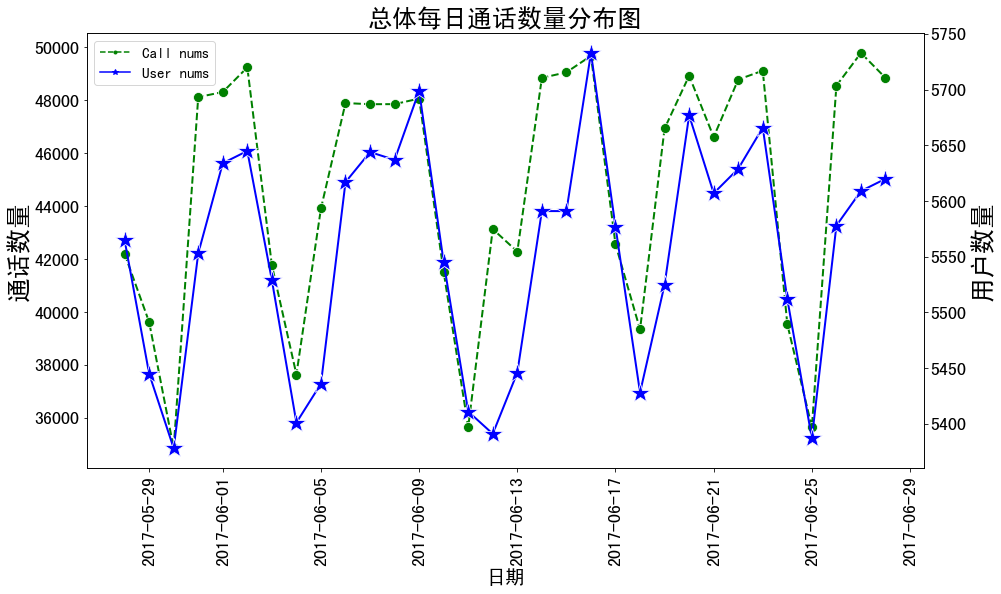

In [17]:
from matplotlib.lines import Line2D

plt.figure(figsize=(15, 8))
g = sns.lineplot(x='date', y='call_num', data=pd.DataFrame({'date':total_dates, 'call_num':total_call_nums}), color='g', linestyle='--', linewidth=2, marker='.', markersize=20)
ax2 = sns.lineplot(ax=g.axes.twinx(), x='date', y='user_num', data=pd.DataFrame({'date':total_dates, 'user_num':total_user_nums}), color='b', linewidth=2, marker='*', markersize=20)
g.legend(loc='upper left', fontsize=15, handles=[Line2D([], [], linestyle='--', marker='.', color="g", label='Call nums'), Line2D([], [], marker='*', color="b", label='User nums')])
plt.title('总体每日通话数量分布图', fontsize=25)
g.set_xlabel("日期", fontsize=20)
g.set_ylabel("通话数量", fontsize=25)
ax2.set_ylabel("用户数量", fontsize=25)
g.xaxis.set_tick_params(labelsize=18, rotation=90)
g.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
plt.xticks(fontsize=12, rotation=60)
plt.show()

0    222167
1    223755
2    240286
3    194013
4    196111
5    165382
6    190497
Name: start_time, dtype: int64


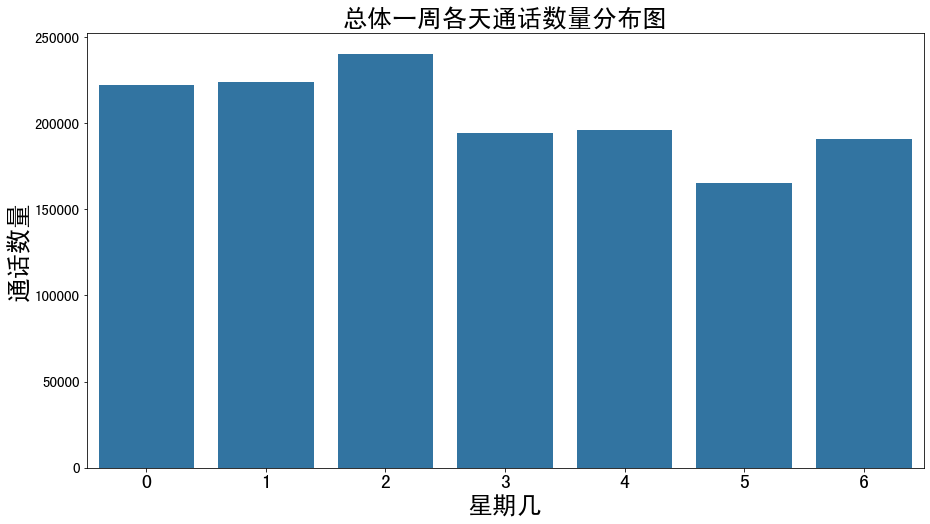

In [18]:
# 总体的一周各天通话数量分布

print(merge_df['start_time'].dt.weekday.value_counts().sort_index())
total_weekdays = list(range(7))
total_weekday_call_nums = list(merge_df['start_time'].dt.weekday.value_counts().sort_index().values)

# 使用seaborn barplot绘制柱状图进行可视化
plt.figure(figsize=(15,8))
ax = sns.barplot(x='weekday', y='call_num', data=pd.DataFrame({'weekday':total_weekdays, 'call_num':total_weekday_call_nums}), color='tab:blue')
ax.axes.set_title('总体一周各天通话数量分布图', fontsize=25)
ax.set_xlabel("星期几",fontsize=25)
ax.set_ylabel("通话数量",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

0       3168
1       1714
2       1396
3       1599
4       2508
5       9172
6      24196
7      49777
8      86872
9     118522
10    130455
11    118092
12     85414
13     83897
14    103171
15    112096
16    122463
17    114373
18     82610
19     75632
20     54368
21     31027
22     13615
23      6074
Name: start_time, dtype: int64


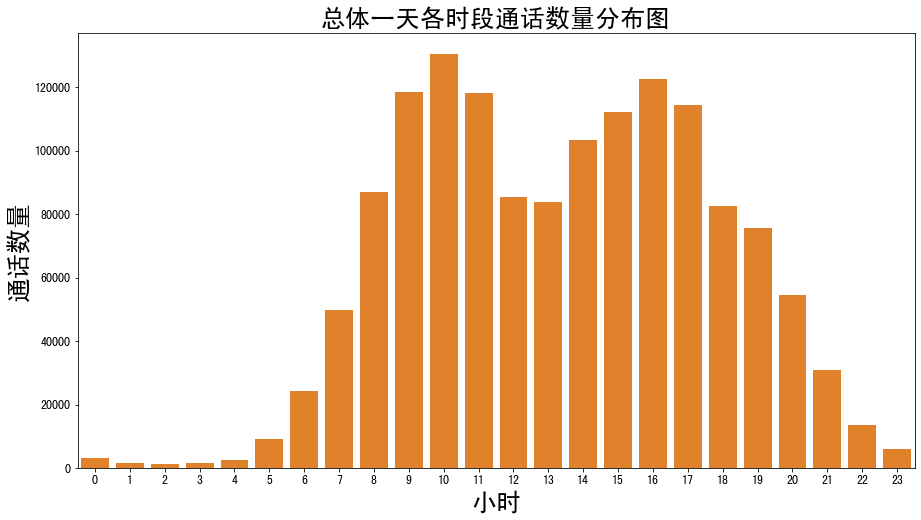

In [19]:
# 总体的一天24h通话数量分布

print(merge_df['start_time'].dt.hour.value_counts().sort_index())
total_hours = list(range(24))
total_hour_call_nums = list(merge_df['start_time'].dt.hour.value_counts().sort_index().values)

# 使用seaborn barplot绘制柱状图进行可视化
plt.figure(figsize=(15,8))
ax = sns.barplot(x='hour', y='call_num', data=pd.DataFrame({'hour':total_hours, 'call_num':total_hour_call_nums}), color='tab:orange')
ax.axes.set_title('总体一天各时段通话数量分布图', fontsize=25)
ax.set_xlabel("小时",fontsize=25)
ax.set_ylabel("通话数量",fontsize=25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

1.0    921271
2.0    262610
3.0    133903
4.0     62111
5.0     50946
0.0      1370
Name: duration, dtype: int64


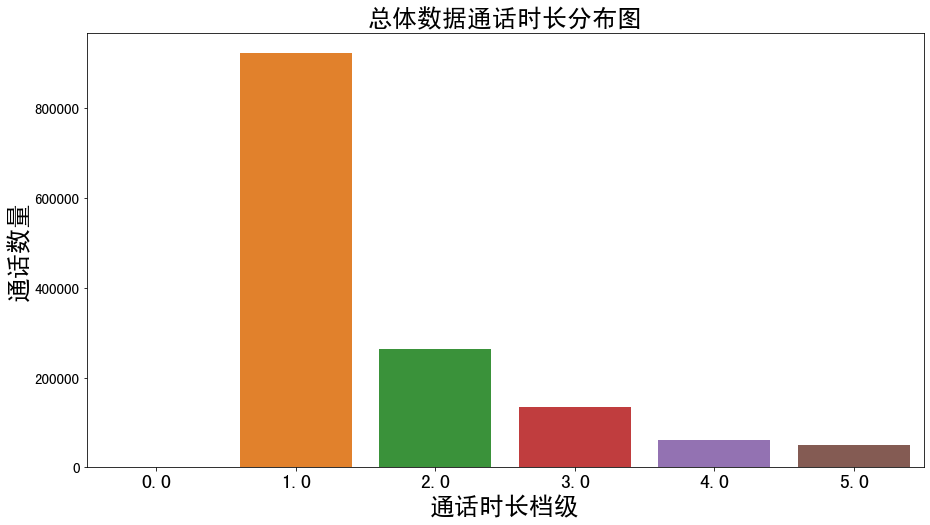

In [20]:
# 总体数据的通话时长分布

print(merge_df['duration'].value_counts())
total_durations = list(merge_df['duration'].value_counts().index)
total_duration_call_nums = list(merge_df['duration'].value_counts().values)

# 使用seaborn barplot绘制柱状图进行可视化
plt.figure(figsize=(15,8))
ax = sns.barplot(x='duration', y='call_num', data=pd.DataFrame({'duration':total_durations, 'call_num':total_duration_call_nums}))
ax.axes.set_title('总体数据通话时长分布图', fontsize=25)
ax.set_xlabel("通话时长档级",fontsize=25)
ax.set_ylabel("通话数量",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

60126021    2835
60160950    2720
60162387    2566
60154287    2274
60077812    2219
            ... 
60031334       1
60124902       1
60125046       1
60154686       1
60051435       1
Name: uid, Length: 6863, dtype: int64


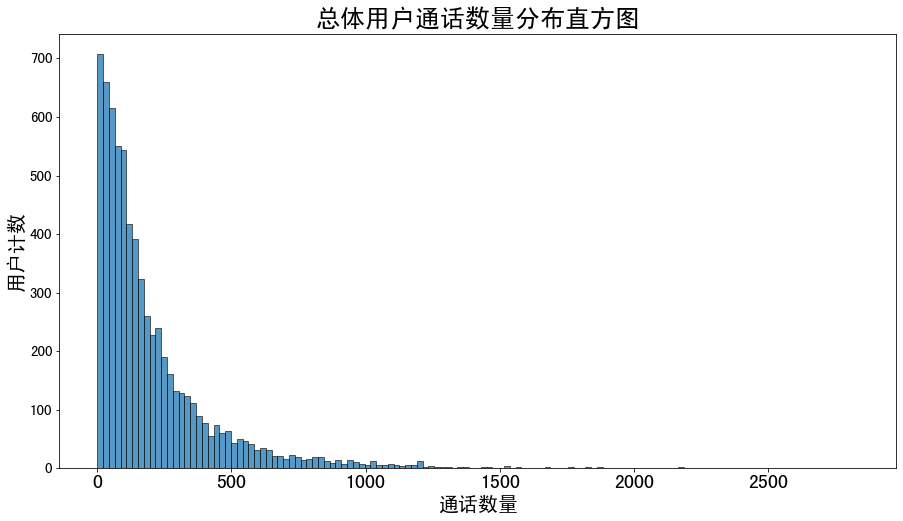

In [21]:
# 总体用户的通话数量分布
print(merge_df['uid'].value_counts())

# 使用seaborn histplot绘制直方图进行可视化
plt.figure(figsize=(15,8))
ax = sns.histplot(data=pd.DataFrame(merge_df['uid'].value_counts()), x='uid')
ax.axes.set_title('总体用户通话数量分布直方图', fontsize=25)
ax.set_xlabel("通话数量",fontsize=20)
ax.set_ylabel("用户计数",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

## 特征工程

### 活跃度分析

#### 用户缺失的通话天数

In [22]:
# 分组统计每个用户的活跃天数（有通话记录的天数）
uid_date_df = merge_df[['uid', 'date']].drop_duplicates()
user_active_days = uid_date_df.groupby(['uid'])['date'].agg(['count']).reset_index()
user_active_days['missing_days'] = len(total_dates) - np.array(user_active_days['count'])

缺失天数为0的用户有2264个，占比0.32988488998980037。
缺失天数为1的用户有762个，占比0.11103016173684978。
缺失天数为2的用户有498个，占比0.07256301908786245。
缺失天数为3的用户有357个，占比0.05201806790033513。
缺失天数大于等于7的用户有2194个，占比0.3196852688328719。
缺失天数大于等于14的用户有1189个，占比0.17324785079411337。


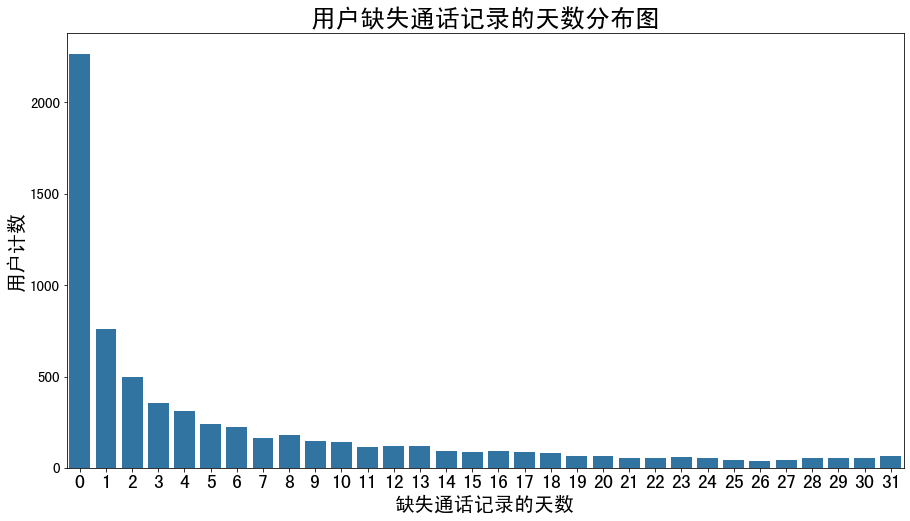

In [23]:
# 对用户的通话缺失天数分布进行可视化
for i in [0, 1, 2, 3]:
    missing_num = user_active_days[user_active_days['missing_days'] == i].shape[0]
    missing_ratio = missing_num / user_active_days.shape[0]
    print("缺失天数为{}的用户有{}个，占比{}。".format(i, missing_num, missing_ratio))

for i in [7, 14]:
    missing_num = user_active_days[user_active_days['missing_days'] >= i].shape[0]
    missing_ratio = missing_num / user_active_days.shape[0]
    print("缺失天数大于等于{}的用户有{}个，占比{}。".format(i, missing_num, missing_ratio))

plt.figure(figsize=(15,8))
x = list(user_active_days['missing_days'].value_counts().sort_index().index)
y = list(user_active_days['missing_days'].value_counts().sort_index())
ax = sns.barplot(x=x, y=y, color='tab:blue')
ax.axes.set_title('用户缺失通话记录的天数分布图', fontsize=25)
ax.set_xlabel("缺失通话记录的天数",fontsize=20)
ax.set_ylabel("用户计数",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

In [24]:
# 分析守信用户与违约用户在缺失通话天数特征上表现出的差异性
# 将缺失通话天数加入到用户信用预测特征中
user_features = pd.merge(user_features, user_active_days[['uid', 'missing_days']], on='uid')

for i in [0, 1, 2]:
    missing_days_i = user_features[user_features['missing_days'] == i]
    user_num = missing_days_i.shape[0]
    non_risk_num = missing_days_i['RISK_Flag'].value_counts()[1]
    non_risk_ratio = non_risk_num / user_num
    print("缺失天数为{}的用户中违约的比例为{}".format(i, non_risk_ratio))

missing_days_3_5 = user_features[(user_features['missing_days'] >= 3) & (user_features['missing_days'] <= 5)]
user_num = missing_days_3_5.shape[0]
non_risk_num = missing_days_3_5['RISK_Flag'].value_counts()[1]
non_risk_ratio = non_risk_num / user_num
print("缺失天数为3到5天的用户中违约的比例为{}".format(non_risk_ratio))

missing_days_5_10 = user_features[(user_features['missing_days'] >= 5) & (user_features['missing_days'] <= 10)]
user_num = missing_days_5_10.shape[0]
non_risk_num = missing_days_5_10['RISK_Flag'].value_counts()[1]
non_risk_ratio = non_risk_num / user_num
print("缺失天数为5到10天的用户中违约的比例为{}".format(non_risk_ratio))

missing_days_10_15 = user_features[(user_features['missing_days'] >= 10) & (user_features['missing_days'] <= 15)]
user_num = missing_days_10_15.shape[0]
non_risk_num = missing_days_10_15['RISK_Flag'].value_counts()[1]
non_risk_ratio = non_risk_num / user_num
print("缺失天数为10到15天的用户中违约的比例为{}".format(non_risk_ratio))

missing_days_15 = user_features[user_features['missing_days'] >= 15]
user_num = missing_days_15.shape[0]
non_risk_num = missing_days_15['RISK_Flag'].value_counts()[1]
non_risk_ratio = non_risk_num / user_num
print("缺失天数为15天以上的用户中违约的比例为{}".format(non_risk_ratio))

缺失天数为0的用户中违约的比例为0.17800353356890458
缺失天数为1的用户中违约的比例为0.3530183727034121
缺失天数为2的用户中违约的比例为0.4578313253012048
缺失天数为3到5天的用户中违约的比例为0.5648854961832062
缺失天数为5到10天的用户中违约的比例为0.6995515695067265
缺失天数为10到15天的用户中违约的比例为0.8043478260869565
缺失天数为15天以上的用户中违约的比例为0.8754578754578755


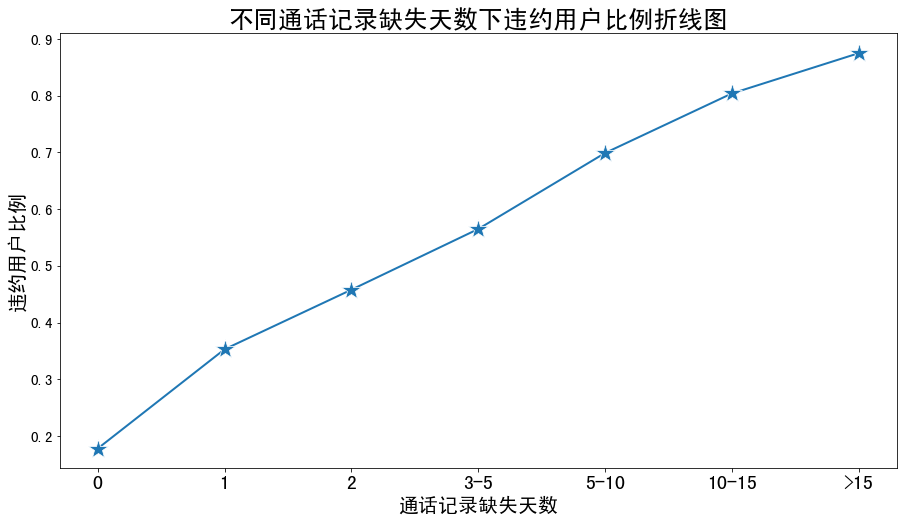

In [25]:
# 使用折线图可视化以上结果
x = ['0', '1', '2', '3-5', '5-10', '10-15', '>15']
y = [0.178, 0.353, 0.458, 0.565, 0.699, 0.804, 0.875]
plt.figure(figsize=(15,8))
ax = sns.lineplot(x=x, y=y, linewidth=2, marker='*', markersize=20)
ax.set_title('不同通话记录缺失天数下违约用户比例折线图', fontsize=25)
ax.set_xlabel("通话记录缺失天数",fontsize=20)
ax.set_ylabel("违约用户比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

In [26]:
# 守信用户与违约用户在该特征上的中位数与标准差
missing_0 = list(user_features[user_features['RISK_Flag']==0]['missing_days'])
missing_1 = list(user_features[user_features['RISK_Flag']==1]['missing_days'])

print("守信用户通话记录缺失天数中位数:", np.median(missing_0))
print("违约用户通话记录缺失天数中位数:", np.median(missing_1))
print("守信用户通话记录缺失天数标准差:", np.std(missing_0))
print("违约用户通话记录缺失天数标准差:", np.std(missing_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(missing_0, missing_1))
print("t检验结果:", stats.ttest_ind(missing_0,missing_1))

守信用户通话记录缺失天数中位数: 0.0
违约用户通话记录缺失天数中位数: 8.0
守信用户通话记录缺失天数标准差: 4.828833731069234
违约用户通话记录缺失天数标准差: 8.923718076942022
levene检验结果: LeveneResult(statistic=1514.8895895875346, pvalue=1.330939883846262e-299)
t检验结果: Ttest_indResult(statistic=-43.69301694248038, pvalue=0.0)


#### 日均通话数量

In [27]:
# 分组统计每个用户的通话数量
user_active_nums = merge_df.groupby(['uid'])['uid'].agg(['count']).reset_index()
# 除以天数求每个用户的日均通话数量
user_active_nums['call_avg'] = user_active_nums['count'] / len(total_dates)
# 0表示主叫，1表示被叫，计算每个用户的日均呼入/呼出通话数量
user_active_nums_out = merge_df[merge_df['call_type']==0].groupby(['uid'])['uid'].agg(['count']).reset_index()
user_active_nums_in = merge_df[merge_df['call_type']==1].groupby(['uid'])['uid'].agg(['count']).reset_index()
user_active_nums_out['callout_avg'] = user_active_nums_out['count'] / len(total_dates)
user_active_nums_in['callin_avg'] = user_active_nums_in['count'] / len(total_dates)
del user_active_nums_out['count']
del user_active_nums_in['count']
user_active_nums = pd.merge(user_active_nums, user_active_nums_out, how='left', on='uid')
user_active_nums = pd.merge(user_active_nums, user_active_nums_in, how='left', on='uid')
user_active_nums = user_active_nums.fillna(0)

In [28]:
nums_risk_flag = pd.merge(user_features[['uid', 'RISK_Flag']], user_active_nums, on='uid')

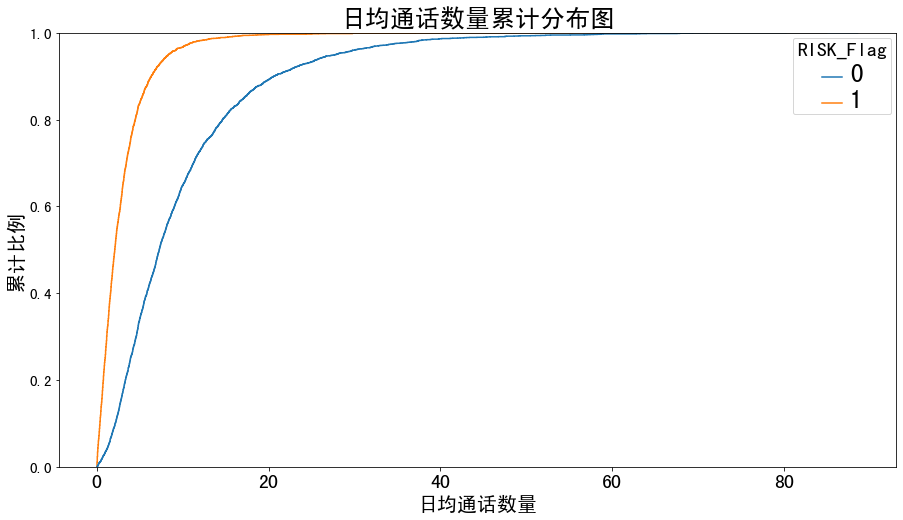

In [29]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=nums_risk_flag, x="call_avg", hue="RISK_Flag")
ax.set_title('日均通话数量累计分布图', fontsize=25)
ax.set_xlabel("日均通话数量",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

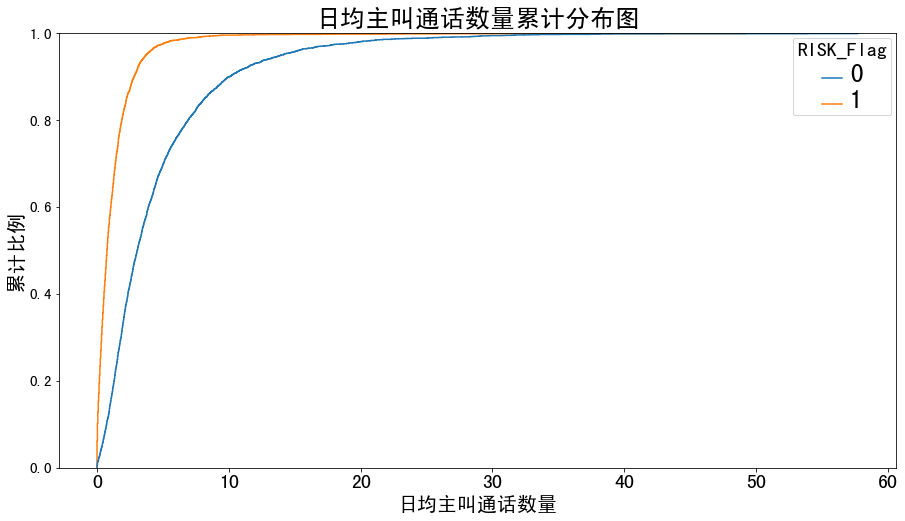

In [30]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=nums_risk_flag, x="callout_avg", hue="RISK_Flag")
ax.set_title('日均主叫通话数量累计分布图', fontsize=25)
ax.set_xlabel("日均主叫通话数量",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

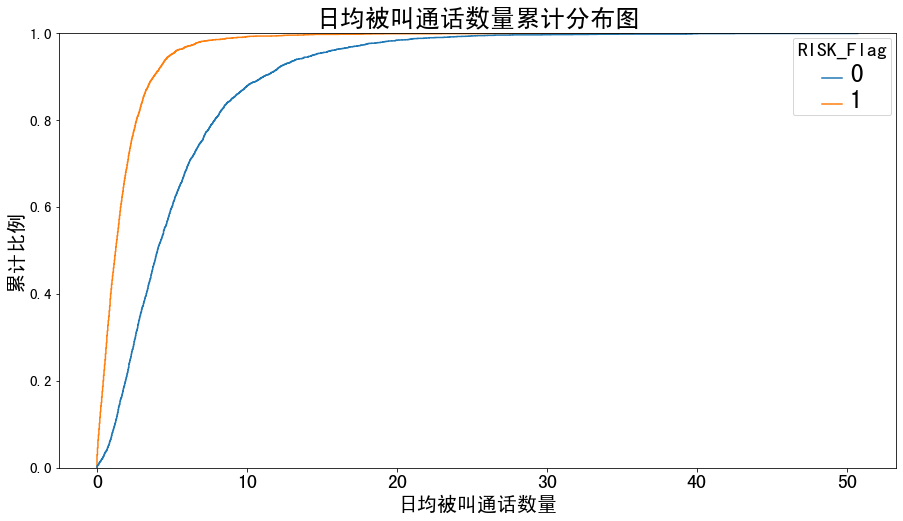

In [31]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=nums_risk_flag, x="callin_avg", hue="RISK_Flag")
ax.set_title('日均被叫通话数量累计分布图', fontsize=25)
ax.set_xlabel("日均被叫通话数量",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

In [32]:
# 将日均通话数量加入到用户信用预测特征中
user_features = pd.merge(user_features, nums_risk_flag[['uid', 'call_avg', 'callout_avg', 'callin_avg']], on='uid')

# 守信用户与违约用户在该特征上的中位数与标准差
nums_0 = list(user_features[user_features['RISK_Flag']==0]['call_avg'])
nums_1 = list(user_features[user_features['RISK_Flag']==1]['call_avg'])

print("守信用户日均通话数量中位数:", np.median(nums_0))
print("违约用户日均通话数量中位数:", np.median(nums_1))
print("守信用户日均通话数量标准差:", np.std(nums_0))
print("违约用户日均通话数量标准差:", np.std(nums_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(nums_0, nums_1))
print("t检验结果:", stats.ttest_ind(nums_0, nums_1))

守信用户日均通话数量中位数: 7.28125
违约用户日均通话数量中位数: 2.09375
守信用户日均通话数量标准差: 9.211813404992208
违约用户日均通话数量标准差: 3.633353813784358
levene检验结果: LeveneResult(statistic=817.0394561397342, pvalue=7.00578119735746e-170)
t检验结果: Ttest_indResult(statistic=40.763650478387916, pvalue=0.0)


#### 用户通话对象数量

In [33]:
# 分组统计每个用户的通话对象数量
opp_df = merge_df[['uid', 'opp_user_num']].drop_duplicates()
user_active_opp_nums = opp_df.groupby(['uid'])['opp_user_num'].agg(['count']).reset_index()
# 呼出统计
opp_df_out = merge_df[merge_df['call_type']==0][['uid', 'opp_user_num']].drop_duplicates()
user_active_opp_nums_out = opp_df_out.groupby(['uid'])['opp_user_num'].agg(['count']).reset_index()
# 呼入统计
opp_df_in = merge_df[merge_df['call_type']==1][['uid', 'opp_user_num']].drop_duplicates()
user_active_opp_nums_in = opp_df_in.groupby(['uid'])['opp_user_num'].agg(['count']).reset_index()

user_active_opp_nums.rename(columns = {'count': 'opp_nums'}, inplace = True)
user_active_opp_nums_out.rename(columns = {'count': 'opp_nums_out'}, inplace = True)
user_active_opp_nums_in.rename(columns = {'count': 'opp_nums_in'}, inplace = True)

user_active_opp_nums = pd.merge(user_active_opp_nums, user_active_opp_nums_out, how='left', on='uid')
user_active_opp_nums = pd.merge(user_active_opp_nums, user_active_opp_nums_in, how='left', on='uid')
user_active_opp_nums = user_active_opp_nums.fillna(0)

nums_opp_flag = pd.merge(user_features[['uid', 'RISK_Flag']], user_active_opp_nums, on='uid')

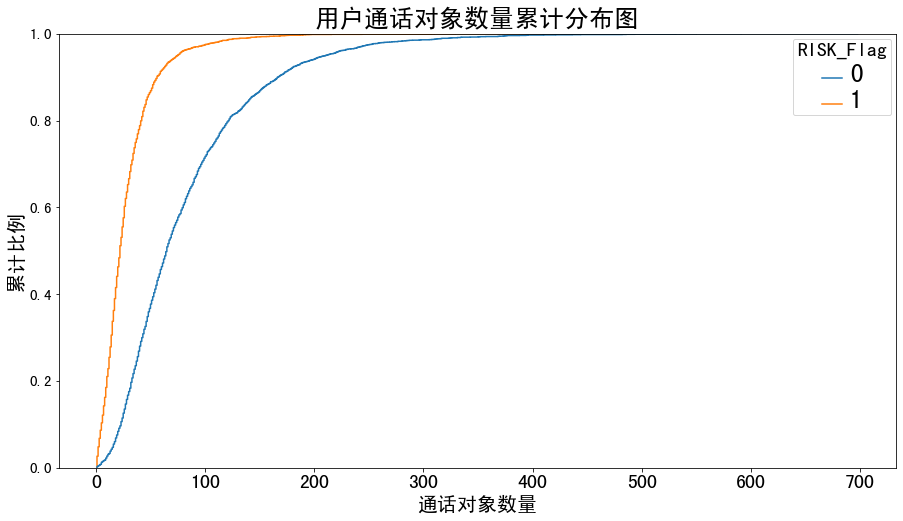

In [34]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=nums_opp_flag, x="opp_nums", hue="RISK_Flag")
ax.set_title('用户通话对象数量累计分布图', fontsize=25)
ax.set_xlabel("通话对象数量",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

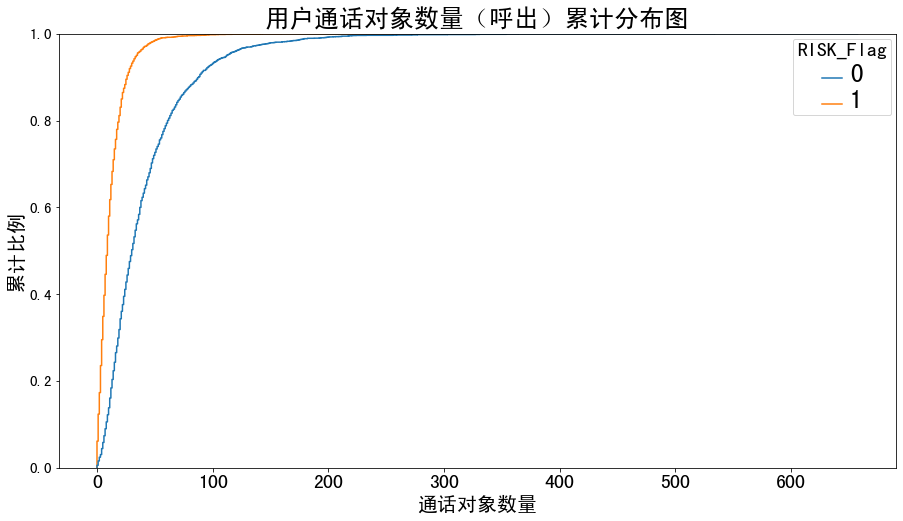

In [35]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=nums_opp_flag, x="opp_nums_out", hue="RISK_Flag")
ax.set_title('用户通话对象数量（呼出）累计分布图', fontsize=25)
ax.set_xlabel("通话对象数量",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

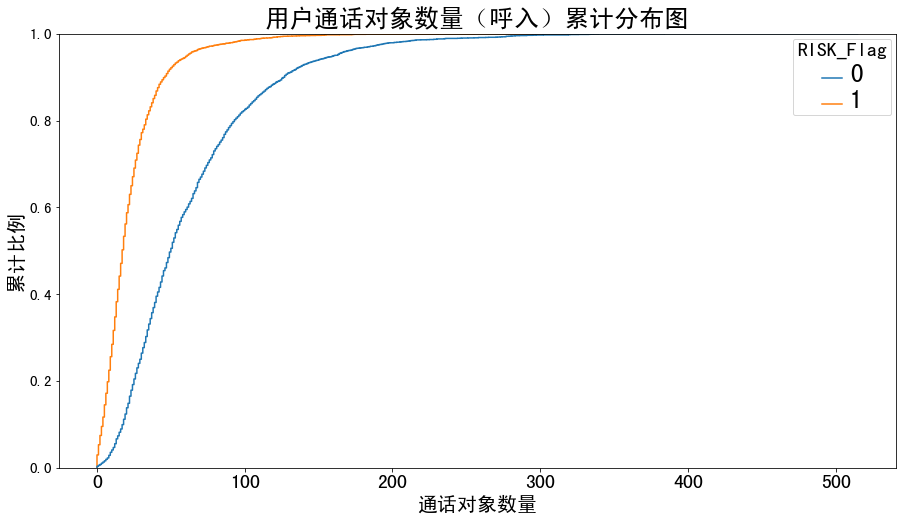

In [36]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=nums_opp_flag, x="opp_nums_in", hue="RISK_Flag")
ax.set_title('用户通话对象数量（呼入）累计分布图', fontsize=25)
ax.set_xlabel("通话对象数量",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

In [37]:
# 将通话对象数量加入到用户信用预测特征中
user_features = pd.merge(user_features, nums_opp_flag[['uid', 'opp_nums', 'opp_nums_in', 'opp_nums_out']], on='uid')

# 守信用户与违约用户在该特征上的中位数与标准差
opp_num_0 = list(user_features[user_features['RISK_Flag']==0]['opp_nums'])
opp_num_1 = list(user_features[user_features['RISK_Flag']==1]['opp_nums'])

print("守信用户通话对象数量中位数:", np.median(opp_num_0))
print("违约用户通话对象数量中位数:", np.median(opp_num_1))
print("守信用户通话对象数量标准差:", np.std(opp_num_0))
print("违约用户通话对象数量标准差:", np.std(opp_num_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(opp_num_0, opp_num_1))
print("t检验结果:", stats.ttest_ind(opp_num_0, opp_num_1))

守信用户通话对象数量中位数: 65.0
违约用户通话对象数量中位数: 22.0
守信用户通话对象数量标准差: 66.88129229851714
违约用户通话对象数量标准差: 28.52860498140115
levene检验结果: LeveneResult(statistic=863.3222641062399, pvalue=7.60441097811464e-179)
t检验结果: Ttest_indResult(statistic=43.50445815828789, pvalue=0.0)


#### 不同时长档级的通话数量

In [38]:
user_duration = merge_df[['uid']].drop_duplicates()

# 档级 0 不考虑在内
for n in [1, 2, 3, 4, 5]:
    dfn = merge_df[merge_df['duration']==n]
    count_duration = dfn.groupby('uid')['duration'].agg('count').reset_index()
    count_duration.rename(columns={'duration':'Duration%s' %(n)},inplace=True)
    user_duration = pd.merge(user_duration, count_duration, on='uid', how='left')

user_duration.fillna(0, inplace=True)
user_duration_risk_flag = pd.merge(user_features[['uid', 'RISK_Flag']], user_duration, on='uid')

In [39]:
user_features = pd.merge(user_features, user_duration_risk_flag[['uid', 'Duration1', 
                            'Duration2', 'Duration3', 'Duration4', 'Duration5']], on='uid')

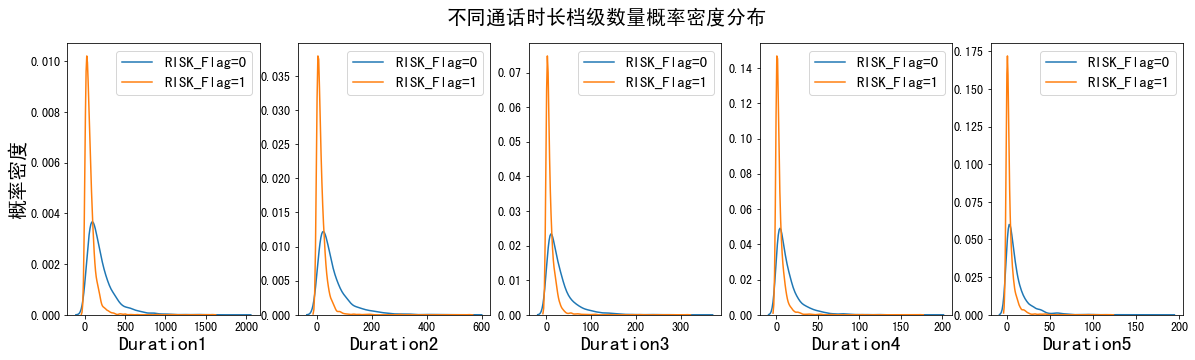

In [40]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('不同通话时长档级数量概率密度分布', fontsize=20)
n = 1
for ax in axs:
    col_name = 'Duration'+str(n)
    sns.kdeplot(user_duration_risk_flag[user_duration_risk_flag['RISK_Flag']==0][col_name], ax=ax, label='RISK_Flag=0')
    sns.kdeplot(user_duration_risk_flag[user_duration_risk_flag['RISK_Flag']==1][col_name], ax=ax, label='RISK_Flag=1')
    ax.xaxis.label.set_size(20)
    ax.set_ylabel("概率密度",fontsize=20)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(fontsize=15)
    if n != 1:
        ax.set(ylabel=None)
    n += 1
plt.show()

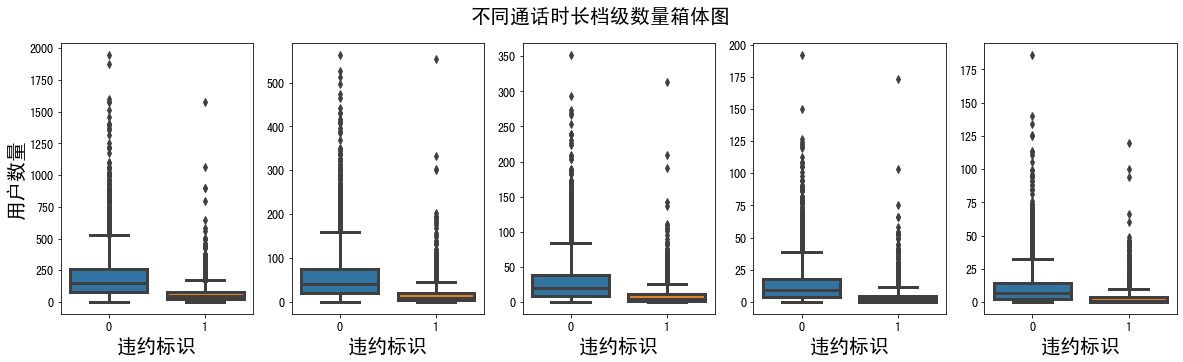

In [41]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('不同通话时长档级数量箱体图', fontsize=20)
n = 1
for ax in axs:
    col_name = 'Duration'+str(n)
    sns.boxplot(ax=ax, x=user_duration_risk_flag['RISK_Flag'], y=user_duration_risk_flag[col_name], linewidth=3)
    ax.set_xlabel("违约标识",fontsize=20)
    ax.set_ylabel("用户数量",fontsize=20)
    ax.tick_params(axis='both', labelsize=12)
    if n != 1:
        ax.set(ylabel=None)
    n+=1
plt.show()

In [42]:
for n in [1, 2, 3, 4, 5]:
    col_name = 'Duration'+str(n)
    ser_0 = user_features[user_features['RISK_Flag']==0][col_name]
    ser_1 = user_features[user_features['RISK_Flag']==1][col_name]
    print("{}特征显著性检验:".format(col_name))
    print("levene检验结果:", stats.levene(ser_0, ser_1))
    print("t检验结果:", stats.ttest_ind(ser_0, ser_1))
    print()

Duration1特征显著性检验:
levene检验结果: LeveneResult(statistic=748.7028913976542, pvalue=1.5199389714803878e-156)
t检验结果: Ttest_indResult(statistic=39.357792184569554, pvalue=1.1451286500774298e-305)

Duration2特征显著性检验:
levene检验结果: LeveneResult(statistic=793.2853512382828, pvalue=2.934724365642255e-165)
t检验结果: Ttest_indResult(statistic=37.99398477277493, pvalue=7.54739779968873e-287)

Duration3特征显著性检验:
levene检验结果: LeveneResult(statistic=737.9404743531707, pvalue=1.9644440410491933e-154)
t检验结果: Ttest_indResult(statistic=35.535543684047155, pvalue=4.900502306900967e-254)

Duration4特征显著性检验:
levene检验结果: LeveneResult(statistic=684.8599077636181, pvalue=5.641160016905779e-144)
t检验结果: Ttest_indResult(statistic=33.210416804667034, pvalue=2.0973590022459864e-224)

Duration5特征显著性检验:
levene检验结果: LeveneResult(statistic=521.3250089873309, pvalue=2.810906492569708e-111)
t检验结果: Ttest_indResult(statistic=28.15762054569164, pvalue=3.565358427995563e-165)



#### 不同漫游类型通话数量

In [43]:
merge_df['roam_type'].value_counts()

0    1307205
4      56530
1      52199
6      14076
5       2182
8         19
Name: roam_type, dtype: int64

In [44]:
user_roam_type = merge_df[['uid']].drop_duplicates()

for n in [0, 1, 4, 5, 6, 8]:
    dfn = merge_df[merge_df['roam_type']==n]
    count_roam_type = dfn.groupby('uid')['roam_type'].agg('count').reset_index()
    count_roam_type.rename(columns={'roam_type':'Roam_type%s' %(n)},inplace=True)
    user_roam_type = pd.merge(user_roam_type, count_roam_type, on='uid', how='left')
    
user_roam_type = user_roam_type.fillna(0)

In [45]:
user_features = pd.merge(user_features, user_roam_type, on='uid')

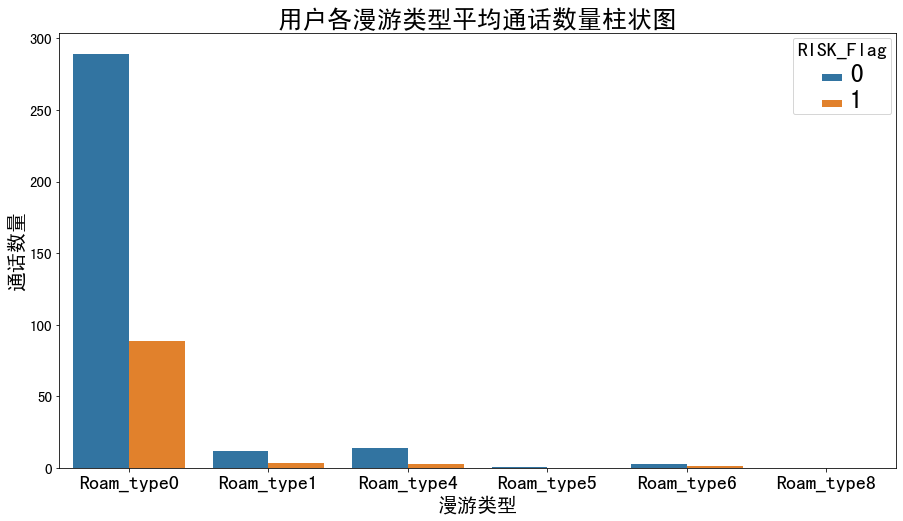

In [46]:
pos_roam_mean = user_features[user_features['RISK_Flag']==0][['Roam_type0', 'Roam_type1', 'Roam_type4', 'Roam_type5', 'Roam_type6', 'Roam_type8']].mean()
neg_roam_mean = user_features[user_features['RISK_Flag']==1][['Roam_type0', 'Roam_type1', 'Roam_type4', 'Roam_type5', 'Roam_type6', 'Roam_type8']].mean()
roam_df = pd.DataFrame({
    'RISK_Flag': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1 ,1],
    'Roam_type': ['Roam_type0', 'Roam_type1', 'Roam_type4', 'Roam_type5', 'Roam_type6', 'Roam_type8'] * 2,
    'call_num_avg': list(pos_roam_mean.values)+list(neg_roam_mean.values)
})

plt.figure(figsize=(15, 8))
ax = sns.barplot(data=roam_df, x='Roam_type', y='call_num_avg', hue='RISK_Flag')
ax.set_title('用户各漫游类型平均通话数量柱状图', fontsize=25)
ax.set_xlabel("漫游类型",fontsize=20)
ax.set_ylabel("通话数量",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title

plt.show()

In [47]:
for n in [0, 1, 4, 5, 6, 8]:
    col_name = 'Roam_type'+str(n)
    ser_0 = user_features[user_features['RISK_Flag']==0][col_name]
    ser_1 = user_features[user_features['RISK_Flag']==1][col_name]
    print("{}特征显著性检验:".format(col_name))
    print("levene检验结果:", stats.levene(ser_0, ser_1))
    print("t检验结果:", stats.ttest_ind(ser_0, ser_1))
    print()

Roam_type0特征显著性检验:
levene检验结果: LeveneResult(statistic=798.8724679631385, pvalue=2.3939405763383375e-166)
t检验结果: Ttest_indResult(statistic=39.40886364594929, pvalue=2.2178657418513257e-306)

Roam_type1特征显著性检验:
levene检验结果: LeveneResult(statistic=79.50661235538185, pvalue=6.075064561016671e-19)
t检验结果: Ttest_indResult(statistic=8.916648044830628, pvalue=6.075064561006334e-19)

Roam_type4特征显著性检验:
levene检验结果: LeveneResult(statistic=58.69272657080406, pvalue=2.0970889203595346e-14)
t检验结果: Ttest_indResult(statistic=7.661117840811749, pvalue=2.0970889203557317e-14)

Roam_type5特征显著性检验:
levene检验结果: LeveneResult(statistic=8.482576506214434, pvalue=0.0035972021906657005)
t检验结果: Ttest_indResult(statistic=2.912486310047557, pvalue=0.003597202190660198)

Roam_type6特征显著性检验:
levene检验结果: LeveneResult(statistic=20.349385241468067, pvalue=6.558802787827037e-06)
t检验结果: Ttest_indResult(statistic=4.511029288473759, pvalue=6.5588027878158476e-06)

Roam_type8特征显著性检验:
levene检验结果: LeveneResult(statistic=3.0492487

#### 不同长话类型通话数量

In [48]:
merge_df['toll_type'].value_counts()

0     1305845
10      65468
1       60406
2         272
3         119
4          93
5           8
Name: toll_type, dtype: int64

In [49]:
user_toll_type = merge_df[['uid']].drop_duplicates()

for n in [0, 1, 2, 3, 4, 5, 10]:
    dfn = merge_df[merge_df['toll_type']==n]
    count_toll_type = dfn.groupby('uid')['toll_type'].agg('count').reset_index()
    count_toll_type.rename(columns={'toll_type':'Toll_type%s' %(n)},inplace=True)
    user_toll_type = pd.merge(user_toll_type, count_toll_type, on='uid', how='left')
    
user_toll_type = user_toll_type.fillna(0)

In [50]:
user_features = pd.merge(user_features, user_toll_type, on='uid')

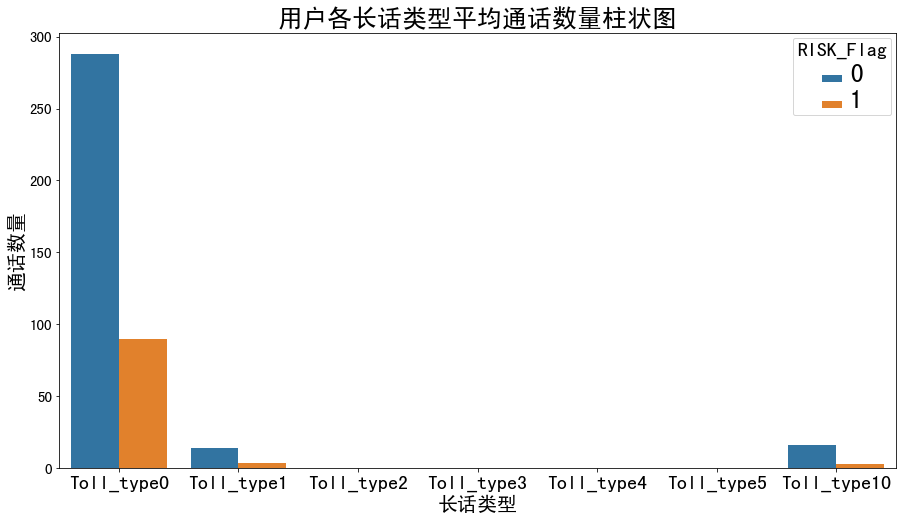

In [51]:
pos_toll_mean = user_features[user_features['RISK_Flag']==0][['Toll_type0', 'Toll_type1', 'Toll_type2', 'Toll_type3', 'Toll_type4', 'Toll_type5', 'Toll_type10']].mean()
neg_toll_mean = user_features[user_features['RISK_Flag']==1][['Toll_type0', 'Toll_type1', 'Toll_type2', 'Toll_type3', 'Toll_type4', 'Toll_type5', 'Toll_type10']].mean()
toll_df = pd.DataFrame({
    'RISK_Flag': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1 ,1, 1],
    'Toll_type': ['Toll_type0', 'Toll_type1', 'Toll_type2', 'Toll_type3', 'Toll_type4', 'Toll_type5', 'Toll_type10'] * 2,
    'call_num_avg': list(pos_toll_mean.values)+list(neg_toll_mean.values)
})

plt.figure(figsize=(15, 8))
ax = sns.barplot(data=toll_df, x='Toll_type', y='call_num_avg', hue='RISK_Flag')
ax.set_title('用户各长话类型平均通话数量柱状图', fontsize=25)
ax.set_xlabel("长话类型",fontsize=20)
ax.set_ylabel("通话数量",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title

plt.show()

In [52]:
for n in [0, 1, 2, 3, 4, 5, 10]:
    col_name = 'Toll_type'+str(n)
    ser_0 = user_features[user_features['RISK_Flag']==0][col_name]
    ser_1 = user_features[user_features['RISK_Flag']==1][col_name]
    print("{}特征显著性检验:".format(col_name))
    print("levene检验结果:", stats.levene(ser_0, ser_1))
    print("t检验结果:", stats.ttest_ind(ser_0, ser_1))
    print()

Toll_type0特征显著性检验:
levene检验结果: LeveneResult(statistic=813.7469948241949, pvalue=3.056641563332801e-169)
t检验结果: Ttest_indResult(statistic=40.92008469835313, pvalue=0.0)

Toll_type1特征显著性检验:
levene检验结果: LeveneResult(statistic=235.6729613363091, pvalue=2.540143207880539e-52)
t检验结果: Ttest_indResult(statistic=15.464631963786609, pvalue=4.688278997956816e-53)

Toll_type2特征显著性检验:
levene检验结果: LeveneResult(statistic=3.562327028992598, pvalue=0.05914699732114593)
t检验结果: Ttest_indResult(statistic=1.8874127871222552, pvalue=0.059146997321056625)

Toll_type3特征显著性检验:
levene检验结果: LeveneResult(statistic=8.773684033064997, pvalue=0.0030665553505374032)
t检验结果: Ttest_indResult(statistic=2.962040518471177, pvalue=0.0030665553505337473)

Toll_type4特征显著性检验:
levene检验结果: LeveneResult(statistic=6.05546799296967, pvalue=0.013887752364112715)
t检验结果: Ttest_indResult(statistic=2.4607860518480007, pvalue=0.013887752364099922)

Toll_type5特征显著性检验:
levene检验结果: LeveneResult(statistic=0.19546680698242808, pvalue=0.658418

### 多样性分析

#### 用户通讯熵（用户与不同的人通话的多样性）

In [53]:
uids = list(user_features['uid'])
user_opp_entropy = []

for uid in uids:
    # 统计每个用户跟其他用户通话的次数
    call_data = merge_df[merge_df['uid']==uid].groupby('opp_user_num')['uid'].agg('count').reset_index()
    # 计算与每个用户与其他用户通话的概率分布
    call_data = call_data['uid'] / sum(call_data['uid'])
    # 计算熵值
    entropy = stats.entropy(call_data)
    user_opp_entropy.append(entropy)

user_opp_entropy_df = pd.DataFrame({'uid': uids, 'opp_entropy': user_opp_entropy})
user_opp_entropy_df = pd.merge(user_features[['uid', 'RISK_Flag']], user_opp_entropy_df)

In [54]:
pos_opp_entropy = list(user_opp_entropy_df[user_opp_entropy_df['RISK_Flag']==0]['opp_entropy'])
neg_opp_entropy = list(user_opp_entropy_df[user_opp_entropy_df['RISK_Flag']==1]['opp_entropy'])

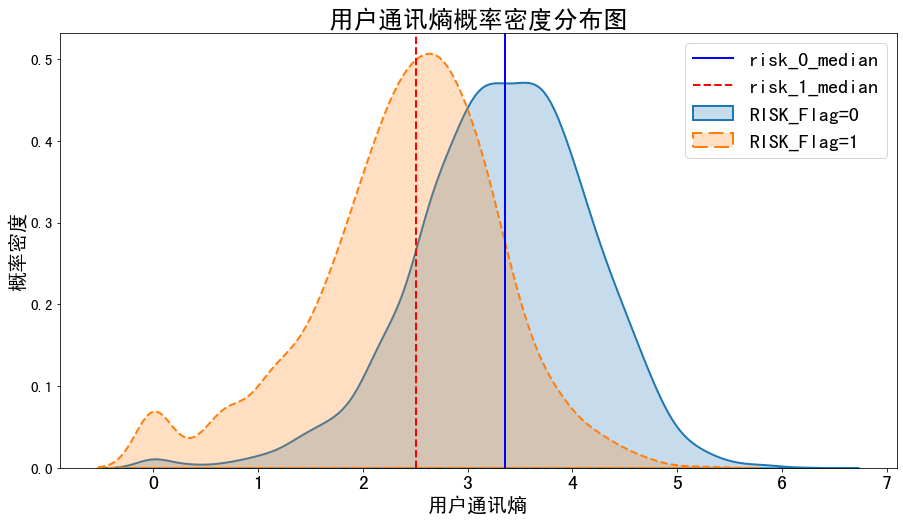

In [55]:
plt.figure(figsize=(15, 8))
sns.kdeplot(pos_opp_entropy, shade=True, label='RISK_Flag=0', linewidth=2)
sns.kdeplot(neg_opp_entropy, shade=True, label='RISK_Flag=1', linestyle='--', linewidth=2)
plt.axvline(np.median(pos_opp_entropy), label='risk_0_median', linewidth=2, color='blue')
plt.axvline(np.median(neg_opp_entropy), label='risk_1_median', linewidth=2, color='red', linestyle='--')
plt.title('用户通讯熵概率密度分布图', fontsize=25)
plt.xlabel("用户通讯熵",fontsize=20)
plt.ylabel("概率密度",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

In [56]:
user_features = pd.merge(user_features, user_opp_entropy_df[['uid', 'opp_entropy']], on='uid')

In [57]:
# 守信用户与违约用户在该特征上的中位数与标准差
opp_ent_0 = list(user_features[user_features['RISK_Flag']==0]['opp_entropy'])
opp_ent_1 = list(user_features[user_features['RISK_Flag']==1]['opp_entropy'])

print("守信用户通讯熵中位数:", np.median(opp_ent_0))
print("违约用户通讯熵中位数:", np.median(opp_ent_1))
print("守信用户通讯熵标准差:", np.std(opp_ent_0))
print("违约用户通讯熵标准差:", np.std(opp_ent_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(opp_ent_0, opp_ent_1))
print("t检验结果:", stats.ttest_ind(opp_ent_0, opp_ent_1))

守信用户通讯熵中位数: 3.360642682965891
违约用户通讯熵中位数: 2.50495629366519
守信用户通讯熵标准差: 0.8369341364464551
违约用户通讯熵标准差: 0.894556530515139
levene检验结果: LeveneResult(statistic=5.362326820707595, pvalue=0.020605642651783208)
t检验结果: Ttest_indResult(statistic=43.6305386062962, pvalue=0.0)


#### 用户日均通讯熵

In [58]:
def get_day_entropy(df):
    day_entropy = []
    for day in set(df['date']):
        day_df = df[df['date']==day]
        day_df = day_df['uid'] / sum(day_df['uid'])
        day_entropy.append(stats.entropy(day_df))
    
    return day_entropy

In [59]:
user_opp_entropy_day = []
for uid in uids:
    user_df = merge_df[merge_df['uid']==uid]
    # 统计每个用户每天与其他用户的通话数量
    call_data = user_df.groupby(['opp_user_num', 'date'])['uid'].agg('count').reset_index()
    # 计算每日的通讯熵，并加和32天得最终值
    user_opp_entropy_day.append(np.sum(get_day_entropy(call_data)))

user_opp_entropy_day_df = pd.DataFrame({'uid': uids, 'opp_entropy_day': user_opp_entropy_day})
user_opp_entropy_day_df = pd.merge(user_features[['uid', 'RISK_Flag']], user_opp_entropy_day_df)
user_opp_entropy_day_df['opp_entropy_day'] = user_opp_entropy_day_df['opp_entropy_day'] / len(total_dates)

In [60]:
pos_opp_entropy_day = list(user_opp_entropy_day_df[user_opp_entropy_day_df['RISK_Flag']==0]['opp_entropy_day'])
neg_opp_entropy_day = list(user_opp_entropy_day_df[user_opp_entropy_day_df['RISK_Flag']==1]['opp_entropy_day'])

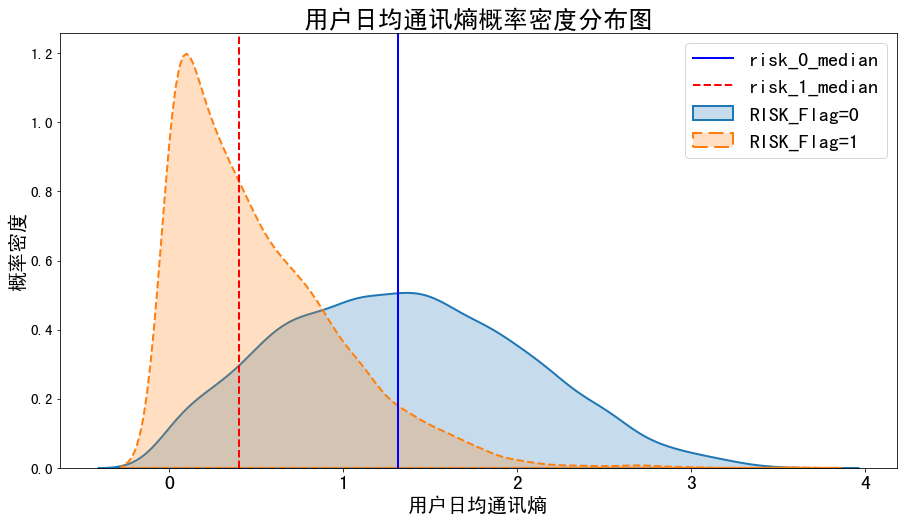

In [61]:
plt.figure(figsize=(15, 8))
sns.kdeplot(pos_opp_entropy_day, shade=True, label='RISK_Flag=0', linewidth=2)
sns.kdeplot(neg_opp_entropy_day, shade=True, label='RISK_Flag=1', linestyle='--', linewidth=2)
plt.axvline(np.median(pos_opp_entropy_day), label='risk_0_median', linewidth=2, color='blue')
plt.axvline(np.median(neg_opp_entropy_day), label='risk_1_median', linewidth=2, color='red', linestyle='--')
plt.title('用户日均通讯熵概率密度分布图', fontsize=25)
plt.xlabel("用户日均通讯熵",fontsize=20)
plt.ylabel("概率密度",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

In [62]:
user_features = pd.merge(user_features, user_opp_entropy_day_df[['uid', 'opp_entropy_day']], on='uid')

In [63]:
# 守信用户与违约用户在该特征上的中位数与标准差
opp_ent_day_0 = list(user_features[user_features['RISK_Flag']==0]['opp_entropy_day'])
opp_ent_day_1 = list(user_features[user_features['RISK_Flag']==1]['opp_entropy_day'])

print("守信用户日均通讯熵中位数:", np.median(opp_ent_day_0))
print("违约用户日均通讯熵中位数:", np.median(opp_ent_day_1))
print("守信用户日均通讯熵标准差:", np.std(opp_ent_day_0))
print("违约用户日均通讯熵标准差:", np.std(opp_ent_day_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(opp_ent_day_0, opp_ent_day_1))
print("t检验结果:", stats.ttest_ind(opp_ent_day_0, opp_ent_day_1))

守信用户日均通讯熵中位数: 1.3162710274459224
违约用户日均通讯熵中位数: 0.40086598078519997
守信用户日均通讯熵标准差: 0.7022347207265667
违约用户日均通讯熵标准差: 0.46722707450762513
levene检验结果: LeveneResult(statistic=618.2009081997289, pvalue=9.798822660368603e-131)
t检验结果: Ttest_indResult(statistic=56.57453496537015, pvalue=0.0)


#### 用户通话时长档级熵（不同通话档级的分布信息）

In [64]:
user_duration_entropy = []
for uid in uids:
    # 统计每个用户每个通话档级的通话数量
    call_data = merge_df[merge_df['uid']==uid].groupby('duration')['uid'].agg('count').reset_index()
    call_data = call_data['uid'] / sum(call_data['uid'])
    # 计算熵值
    entropy = stats.entropy(call_data)
    
    user_duration_entropy.append(entropy)

user_duration_entropy_df = pd.DataFrame({'uid': uids, 'duration_entropy': user_duration_entropy})
user_duration_entropy_df = pd.merge(user_features[['uid', 'RISK_Flag']], user_duration_entropy_df)

In [65]:
pos_duration_entropy = list(user_duration_entropy_df[user_duration_entropy_df['RISK_Flag']==0]['duration_entropy'])
neg_duration_entropy = list(user_duration_entropy_df[user_duration_entropy_df['RISK_Flag']==1]['duration_entropy'])

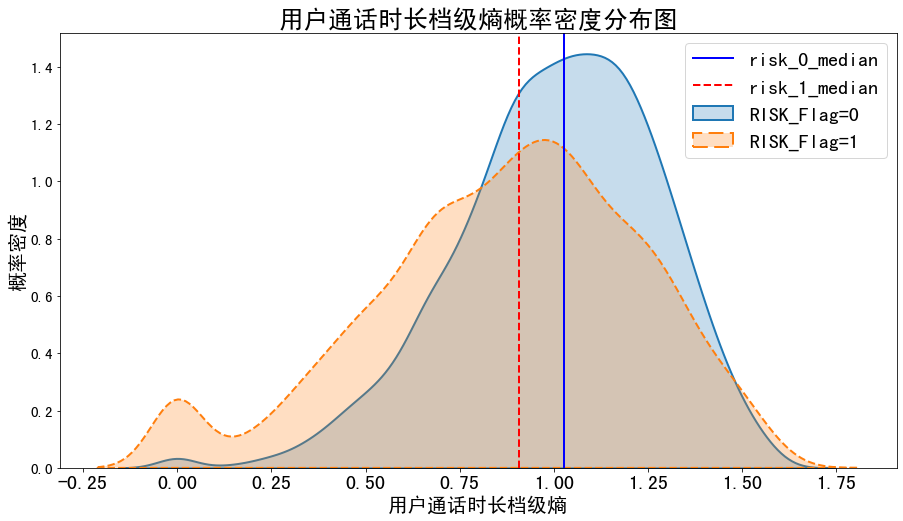

In [66]:
plt.figure(figsize=(15, 8))
sns.kdeplot(pos_duration_entropy , shade=True, label='RISK_Flag=0', linewidth=2)
sns.kdeplot(neg_duration_entropy , shade=True, label='RISK_Flag=1', linestyle='--', linewidth=2)
plt.axvline(np.median(pos_duration_entropy ), label='risk_0_median', linewidth=2, color='blue')
plt.axvline(np.median(neg_duration_entropy ), label='risk_1_median', linewidth=2, color='red', linestyle='--')
plt.title('用户通话时长档级熵概率密度分布图', fontsize=25)
plt.xlabel("用户通话时长档级熵",fontsize=20)
plt.ylabel("概率密度",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

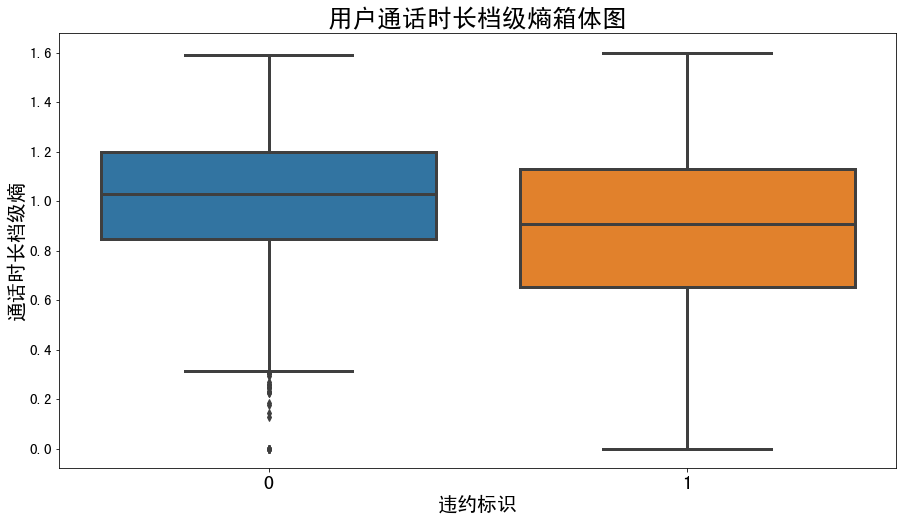

In [67]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x=user_duration_entropy_df['RISK_Flag'], y=user_duration_entropy_df["duration_entropy"], linewidth=3)
plt.title('用户通话时长档级熵箱体图', fontsize=25)
ax.set_xlabel('违约标识', fontsize=20)
ax.set_ylabel('通话时长档级熵', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

In [68]:
user_features = pd.merge(user_features, user_duration_entropy_df[['uid', 'duration_entropy']], on='uid')

In [69]:
# 守信用户与违约用户在该特征上的中位数与标准差
dura_ent_0 = list(user_features[user_features['RISK_Flag']==0]['duration_entropy'])
dura_ent_1 = list(user_features[user_features['RISK_Flag']==1]['duration_entropy'])

print("守信用户通话时长档级熵中位数:", np.median(dura_ent_0))
print("违约用户通话时长档级熵中位数:", np.median(dura_ent_1))
print("守信用户通话时长档级熵标准差:", np.std(dura_ent_0))
print("违约用户通话时长档级熵标准差:", np.std(dura_ent_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(dura_ent_0, dura_ent_1))
print("t检验结果:", stats.ttest_ind(dura_ent_0, dura_ent_1))

守信用户通话时长档级熵中位数: 1.0268434534316129
违约用户通话时长档级熵中位数: 0.9065815098125501
守信用户通话时长档级熵标准差: 0.26533649736438775
违约用户通话时长档级熵标准差: 0.35703265483290375
levene检验结果: LeveneResult(statistic=254.62380985210194, pvalue=2.6038387261315294e-56)
t检验结果: Ttest_indResult(statistic=17.72684415769117, pvalue=8.7417790467456e-69)


### 规律性分析

#### 工作日与周末通话数量差

In [70]:
# 填充一列 “星期几” 列
merge_df['week'] = [int(i.strftime("%w")) for i in merge_df['date']]

In [71]:
user_callnum_weekday = []
user_callnum_weekend = []

for uid in uids:
    user_df = merge_df[merge_df['uid']==uid]
    
    # 工作日通话数量
    call_data = user_df[(user_df['week']>0) & (user_df['week']<=5)]
    if len(call_data) == 0:
        user_callnum_weekday.append(0)
    else:
        user_callnum_weekday.append(len(call_data))
    
    # 周末通话数量
    call_data = user_df[(user_df['week']==0) | (user_df['week']==6)]
    if len(call_data) == 0:
        user_callnum_weekend.append(0)
    else:
        user_callnum_weekend.append(len(call_data))

In [72]:
user_week_call_df = pd.DataFrame({
    'uid': uids,
    'RISK_Flag': list(user_features['RISK_Flag']),
    'callnum_weekday': user_callnum_weekday,
    'callnum_weekend': user_callnum_weekend
})

user_week_call_df['callnum_diff'] = user_week_call_df['callnum_weekday'] - user_week_call_df['callnum_weekend']

In [73]:
user_features = pd.merge(user_features, user_week_call_df[['uid', 'callnum_diff']], on='uid')

In [74]:
pos_calldiff = user_week_call_df[user_week_call_df['RISK_Flag']==0]['callnum_diff']
neg_calldiff = user_week_call_df[user_week_call_df['RISK_Flag']==1]['callnum_diff']

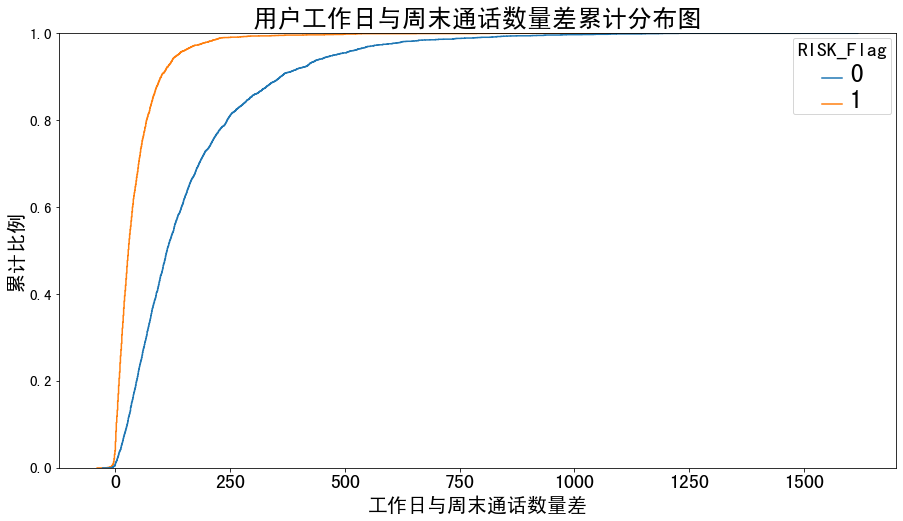

In [75]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=user_week_call_df, x="callnum_diff", hue="RISK_Flag")
ax.set_title('用户工作日与周末通话数量差累计分布图', fontsize=25)
ax.set_xlabel("工作日与周末通话数量差",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

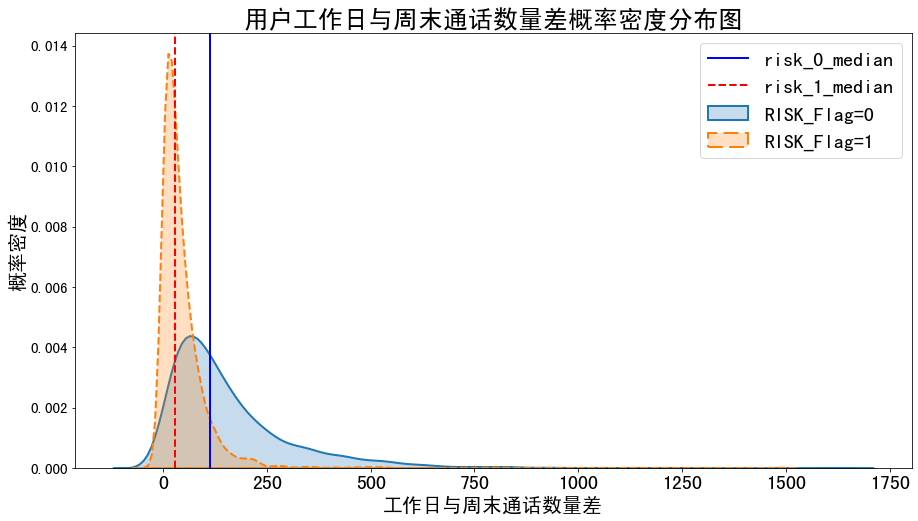

In [76]:
plt.figure(figsize=(15, 8))
sns.kdeplot(pos_calldiff , shade=True, label='RISK_Flag=0', linewidth=2)
sns.kdeplot(neg_calldiff , shade=True, label='RISK_Flag=1', linestyle='--', linewidth=2)
plt.axvline(np.median(pos_calldiff), label='risk_0_median', linewidth=2, color='blue')
plt.axvline(np.median(neg_calldiff), label='risk_1_median', linewidth=2, color='red', linestyle='--')
plt.title('用户工作日与周末通话数量差概率密度分布图', fontsize=25)
plt.xlabel("工作日与周末通话数量差",fontsize=20)
plt.ylabel("概率密度",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

In [77]:
# 守信用户与违约用户在该特征上的中位数与标准差
print("守信用户工作日与周末通话数量差中位数:", np.median(pos_calldiff))
print("违约用户工作日与周末通话数量差中位数:", np.median(neg_calldiff))
print("守信用户工作日与周末通话数量差标准差:", np.std(pos_calldiff))
print("违约用户工作日与周末通话数量差标准差:", np.std(neg_calldiff))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(pos_calldiff, neg_calldiff))
print("t检验结果:", stats.ttest_ind(pos_calldiff, neg_calldiff))

守信用户工作日与周末通话数量差中位数: 113.0
违约用户工作日与周末通话数量差中位数: 29.0
守信用户工作日与周末通话数量差标准差: 160.26410711395104
违约用户工作日与周末通话数量差标准差: 61.84252808596312
levene检验结果: LeveneResult(statistic=865.0068250473173, pvalue=3.595938811545372e-179)
t检验结果: Ttest_indResult(statistic=39.58621193188945, pvalue=7.34133129537511e-309)


#### 工作日与周末通话对象数量差

In [78]:
user_oppnum_weekday = []
user_oppnum_weekend = []

for uid in uids:
    user_df = merge_df[merge_df['uid']==uid]
    
    # 工作日通话对象数量
    call_data = user_df[(user_df['week']>0) & (user_df['week']<=5)]
    if len(call_data) == 0:
        user_oppnum_weekday.append(0)
    else:
        user_oppnum_weekday.append(call_data['opp_user_num'].nunique())
        
    # 周末通话对象数量
    call_data = user_df[(user_df['week']==0) | (user_df['week']==6)]
    if len(call_data) == 0:
        user_oppnum_weekend.append(0)
    else:
        call_data = call_data.groupby(['opp_user_num'])['uid'].agg('count').reset_index()
        user_oppnum_weekend.append(call_data['opp_user_num'].nunique())

In [79]:
user_week_opp_df = pd.DataFrame({
    'uid': uids,
    'RISK_Flag': list(user_features['RISK_Flag']),
    'oppnum_weekday': user_oppnum_weekday,
    'oppnum_weekend': user_oppnum_weekend
})

user_week_opp_df['oppnum_diff'] = user_week_opp_df['oppnum_weekday'] - user_week_opp_df['oppnum_weekend']

In [80]:
user_features = pd.merge(user_features, user_week_opp_df[['uid', 'oppnum_diff']], on='uid')

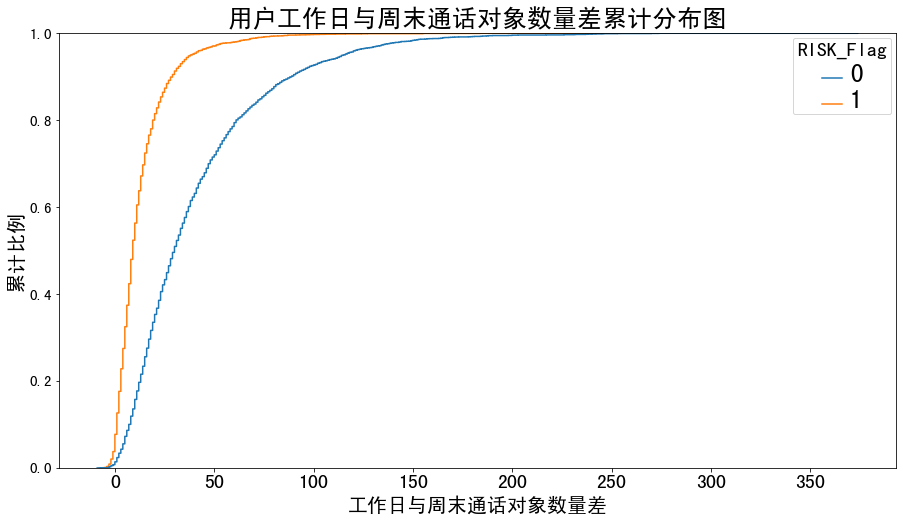

In [81]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=user_week_opp_df, x="oppnum_diff", hue="RISK_Flag")
ax.set_title('用户工作日与周末通话对象数量差累计分布图', fontsize=25)
ax.set_xlabel("工作日与周末通话对象数量差",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

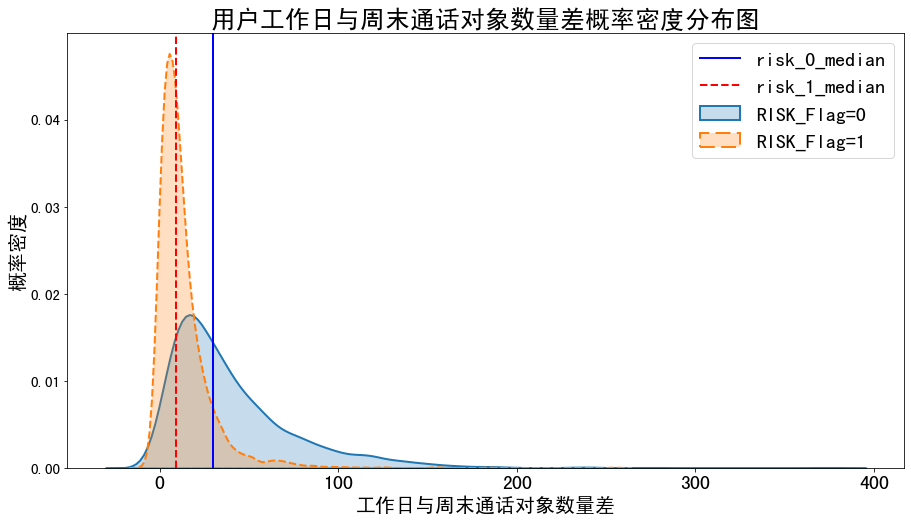

In [82]:
pos_oppdiff = user_week_opp_df[user_week_opp_df['RISK_Flag']==0]['oppnum_diff']
neg_oppdiff = user_week_opp_df[user_week_opp_df['RISK_Flag']==1]['oppnum_diff']

plt.figure(figsize=(15, 8))
sns.kdeplot(pos_oppdiff , shade=True, label='RISK_Flag=0', linewidth=2)
sns.kdeplot(neg_oppdiff , shade=True, label='RISK_Flag=1', linestyle='--', linewidth=2)
plt.axvline(np.median(pos_oppdiff), label='risk_0_median', linewidth=2, color='blue')
plt.axvline(np.median(neg_oppdiff), label='risk_1_median', linewidth=2, color='red', linestyle='--')
plt.title('用户工作日与周末通话对象数量差概率密度分布图', fontsize=25)
plt.xlabel("工作日与周末通话对象数量差",fontsize=20)
plt.ylabel("概率密度",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

In [83]:
# 守信用户与违约用户在该特征上的中位数与标准差
print("守信用户工作日与周末通话对象数量差中位数:", np.median(pos_oppdiff))
print("违约用户工作日与周末通话对象数量差中位数:", np.median(neg_oppdiff))
print("守信用户工作日与周末通话对象数量差标准差:", np.std(pos_oppdiff))
print("违约用户工作日与周末通话对象数量差标准差:", np.std(neg_oppdiff))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(pos_oppdiff, neg_oppdiff))
print("t检验结果:", stats.ttest_ind(pos_oppdiff, neg_oppdiff))

守信用户工作日与周末通话对象数量差中位数: 30.0
违约用户工作日与周末通话对象数量差中位数: 9.0
守信用户工作日与周末通话对象数量差标准差: 36.78330256722403
违约用户工作日与周末通话对象数量差标准差: 15.368629497774874
levene检验结果: LeveneResult(statistic=902.2142610949924, pvalue=2.4549552470815374e-186)
t检验结果: Ttest_indResult(statistic=40.16459382794399, pvalue=0.0)


#### 每日/周通话对象数量方差

In [84]:
from datetime import date, datetime

date_list = list(merge_df['date'].drop_duplicates().sort_values())
date_list = [datetime.strptime(str(day), '%Y-%m-%d') for day in date_list]
weekday_count = [int(i.strftime('%w')) for i in date_list]
weekday_count = [weekday_count.count(i) for i in range(7)]
weekday_count

[5, 5, 5, 5, 4, 4, 4]

In [85]:
opp_regularity_df = merge_df[['uid', 'opp_user_num', 'date', 'week']].drop_duplicates()
user_opp_nums = opp_regularity_df.groupby(['uid', 'date', 'week'])['opp_user_num'].agg('count').reset_index()
user_opp_nums2 = opp_regularity_df.groupby(['uid', 'date'])['opp_user_num'].agg('count').reset_index()
opp_variance_all = merge_df[['uid']].drop_duplicates()
opp_variance_week = opp_variance_all.copy()
opp_regularity = opp_variance_all.copy()

for weekday in range(7):
    user_opp_nums_all = user_opp_nums[['uid']].drop_duplicates()
    user_opp_nums_sub = user_opp_nums[user_opp_nums['week']==weekday]
    for day in set(user_opp_nums_sub['date']):
        user_opp_nums_sub_sub = user_opp_nums_sub[user_opp_nums_sub['date']==day]
        user_opp_nums_all = pd.merge(user_opp_nums_all, user_opp_nums_sub_sub[['uid', 'opp_user_num']], how='left')
        user_opp_nums_all.rename(columns={'opp_user_num': day}, inplace=True)
    
    user_opp_nums_all = user_opp_nums_all.where(user_opp_nums_all.notnull(), 0)
    opp_variance_all = pd.merge(opp_variance_all, user_opp_nums_all, how='left')
    opp_variance_data = opp_variance_all.values[:,1+sum(weekday_count[:weekday]):1+sum(weekday_count[:weekday+1])]
    opp_variance_week['opp_variance%s' %(weekday)] = np.var(opp_variance_data, axis=1)
    
opp_regularity['opp_variance_all'] = np.var(opp_variance_all.values[:,1:], axis=1)
opp_regularity['opp_variance_week'] = np.mean(opp_variance_week.values[:,1:], axis=1)
opp_regularity.reset_index(drop=True, inplace=True)

In [86]:
user_features = pd.merge(user_features, opp_regularity[['uid', 'opp_variance_all', 'opp_variance_week']], on='uid')

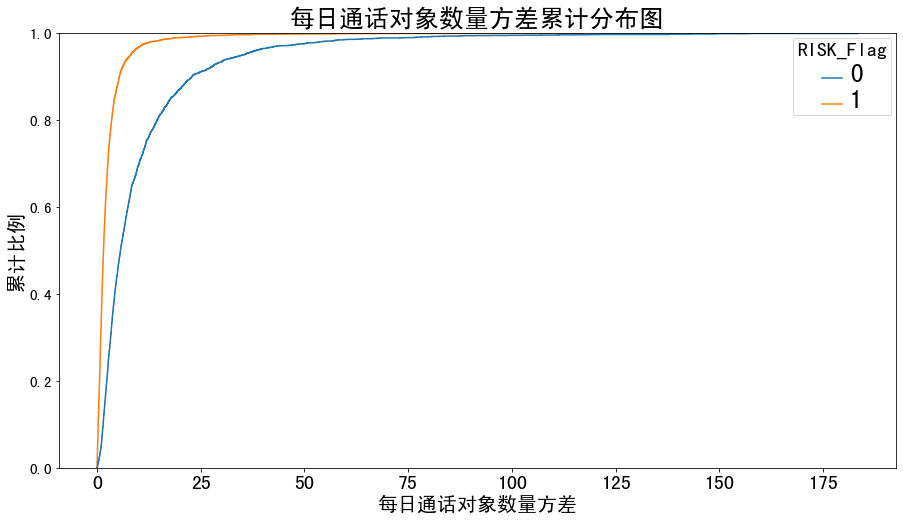

In [87]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=user_features, x="opp_variance_all", hue="RISK_Flag")
ax.set_title('每日通话对象数量方差累计分布图', fontsize=25)
ax.set_xlabel("每日通话对象数量方差",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

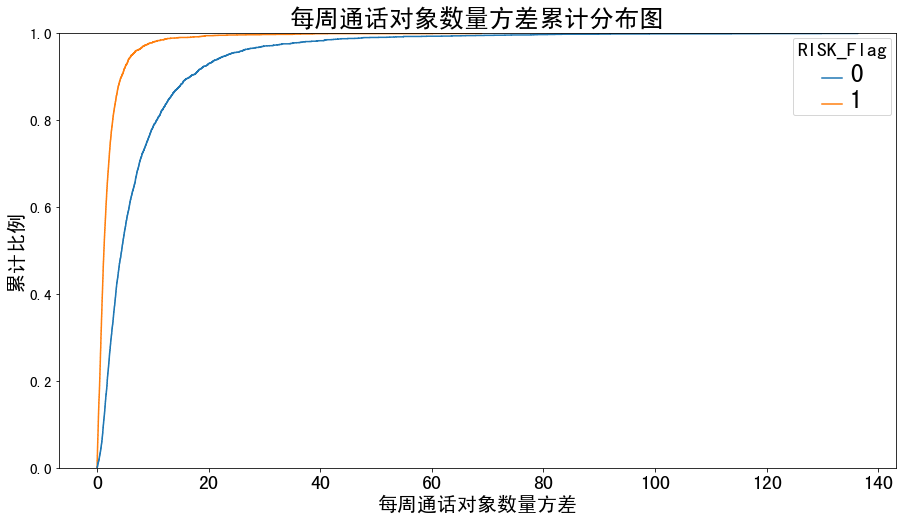

In [88]:
plt.figure(figsize=(15,8))
ax = sns.ecdfplot(data=user_features, x="opp_variance_week", hue="RISK_Flag")
ax.set_title('每周通话对象数量方差累计分布图', fontsize=25)
ax.set_xlabel("每周通话对象数量方差",fontsize=20)
ax.set_ylabel("累计比例",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize=25) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title
plt.show()

In [89]:
opp_var_all_0 = user_features[user_features['RISK_Flag']==0]['opp_variance_all']
opp_var_all_1 = user_features[user_features['RISK_Flag']==1]['opp_variance_all']
opp_var_week_0 = user_features[user_features['RISK_Flag']==0]['opp_variance_week']
opp_var_week_1 = user_features[user_features['RISK_Flag']==1]['opp_variance_week']


# 守信用户与违约用户在该特征上的中位数与标准差
print("守信用户每日通话对象数量方差中位数:", np.median(opp_var_all_0))
print("违约用户每日通话对象数量方差中位数:", np.median(opp_var_all_1))
print("守信用户每日通话对象数量方差标准差:", np.std(opp_var_all_0))
print("违约用户每日通话对象数量方差标准差:", np.std(opp_var_all_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(opp_var_all_0, opp_var_all_1))
print("t检验结果:", stats.ttest_ind(opp_var_all_0, opp_var_all_1))


print()

# 守信用户与违约用户在该特征上的中位数与标准差
print("守信用户每周通话对象数量方差中位数:", np.median(opp_var_week_0))
print("违约用户每周通话对象数量方差中位数:", np.median(opp_var_week_1))
print("守信用户每周通话对象数量方差标准差:", np.std(opp_var_week_0))
print("违约用户每周通话对象数量方差标准差:", np.std(opp_var_week_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(opp_var_week_0, opp_var_week_1))
print("t检验结果:", stats.ttest_ind(opp_var_week_0, opp_var_week_1))

守信用户每日通话对象数量方差中位数: 5.6318359375
违约用户每日通话对象数量方差中位数: 1.55859375
守信用户每日通话对象数量方差标准差: 14.54586343510665
违约用户每日通话对象数量方差标准差: 4.487219990296265
levene检验结果: LeveneResult(statistic=534.9108866192357, pvalue=5.0628705625647546e-114)
t检验结果: Ttest_indResult(statistic=29.26358064740928, pvalue=1.6851685819996809e-177)

守信用户每周通话对象数量方差中位数: 4.416785714285715
违约用户每周通话对象数量方差中位数: 1.2382142857142857
守信用户每周通话对象数量方差标准差: 10.055517324531131
违约用户每周通话对象数量方差标准差: 3.3575810939383497
levene检验结果: LeveneResult(statistic=520.0911372423302, pvalue=4.992919277506922e-111)
t检验结果: Ttest_indResult(statistic=29.677569434711838, pvalue=3.296317513157865e-182)


#### 集中度规律性

In [90]:
# 通话的时间窗口（划为4个时间窗口）
merge_df['window'] = [int(i.strftime('%H')) for i in merge_df['start_time']]
merge_df['window'] = [int(i/6) for i in merge_df['window'].values]
merge_df.window.value_counts()

2    621414
1    527914
3    263326
0     19557
Name: window, dtype: int64

In [91]:
user_concen_regularity = merge_df[['uid']].drop_duplicates()
user_opp_nums = merge_df.groupby(['uid', 'date', 'week', 'window', 'opp_user_num'])['opp_user_num'].agg(['count']).reset_index()
topN = 1
user_opp_nums_fen = user_opp_nums.groupby(['uid', 'date', 'week', 'window']).head(topN)
# 每个用户在某天某时间窗口 联系最多的人 以及 次数
user_opp_nums_fen = user_opp_nums_fen.groupby(['uid', 'date', 'week', 'window'])['count'].agg(['sum']).reset_index()
# 每个用户在某天某时间窗口 所有联系人 和 次数 加和
user_opp_nums_sum = user_opp_nums.groupby(['uid', 'date', 'week', 'window'])['count'].agg(['sum']).reset_index()
user_opp_nums_fen.rename(columns={'sum':'maxsum'}, inplace = True)
# 计算集中度规律：在某天某时间窗口 用户与其最频繁的联系人通话的概率
user_opp_nums = pd.merge(user_opp_nums_fen, user_opp_nums_sum)
user_opp_nums['concen'] = user_opp_nums['maxsum'] / user_opp_nums['sum']
user_opp_nums = user_opp_nums.groupby(['uid', 'week', 'window'])['concen'].agg(['sum']).reset_index()
user_opp_nums_all = merge_df[['uid']].drop_duplicates()
for window in range(4):
    for weekday in range(7):
        # 某天某时间窗口 用户联系最多人的次数
        user_opp_nums_sub = user_opp_nums[(user_opp_nums['week'] == weekday) & (user_opp_nums['window'] == window)]
        # 
        user_opp_nums_sub['concen'] = user_opp_nums['sum'] / weekday_count[weekday]
        user_opp_nums_all = pd.merge(user_opp_nums_all, user_opp_nums_sub[['uid', 'concen']], how='left')
        user_opp_nums_all.rename(columns={'concen':'concen_week%s_%s' %(weekday, window)}, inplace = True)
    
user_opp_nums_all = user_opp_nums_all.where(user_opp_nums_all.notnull(), 0)
user_concen_regularity = pd.merge(user_concen_regularity, user_opp_nums_all)
user_concen_regularity['concen_all'] = np.mean(user_concen_regularity.values[:,1:], axis=1)
user_concen_regularity['concen_var'] = np.var(user_concen_regularity.values[:,1:], axis=1)

/var/folders/5t/z7bt4m315wj81r2gbd8ljds80000gn/T/ipykernel_24840/4278138348.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_opp_nums_sub['concen'] = user_opp_nums['sum'] / weekday_count[weekday]


In [92]:
user_features['concen_all'] = user_concen_regularity['concen_all']

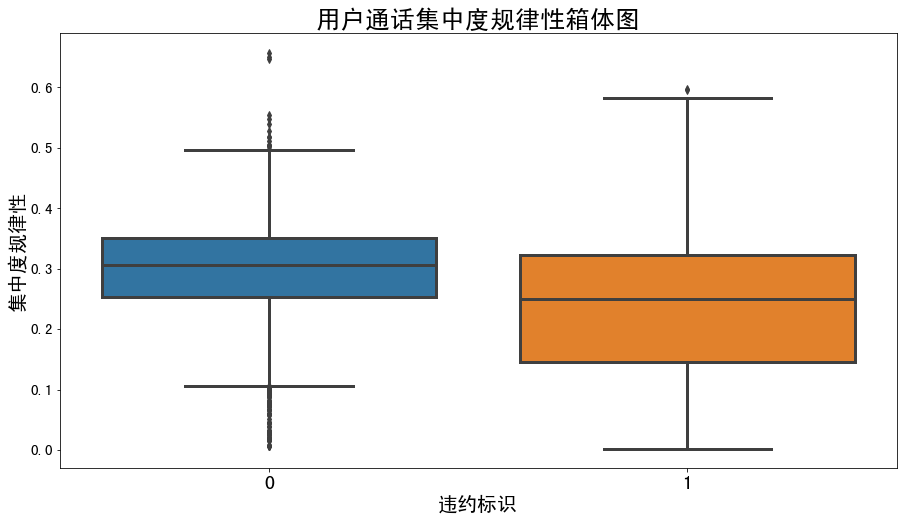

In [93]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x=user_features['RISK_Flag'], y=user_features["concen_all"], linewidth=3)
plt.title('用户通话集中度规律性箱体图', fontsize=25)
ax.set_xlabel('违约标识', fontsize=20)
ax.set_ylabel('集中度规律性', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

In [94]:
concen_all_0 = user_features[user_features['RISK_Flag']==0]['concen_all']
concen_all_1 = user_features[user_features['RISK_Flag']==1]['concen_all']

# 守信用户与违约用户在该特征上的中位数与标准差
print("守信用户集中度规律性中位数:", np.median(concen_all_0))
print("违约用户集中度规律性中位数:", np.median(concen_all_1))
print("守信用户集中度规律性标准差:", np.std(concen_all_0))
print("违约用户集中度规律性标准差:", np.std(concen_all_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(concen_all_0, concen_all_1))
print("t检验结果:", stats.ttest_ind(concen_all_0, concen_all_1))

守信用户集中度规律性中位数: 0.3066071428571429
违约用户集中度规律性中位数: 0.24931228741496597
守信用户集中度规律性标准差: 0.08001916515188624
违约用户集中度规律性标准差: 0.11408753595845922
levene检验结果: LeveneResult(statistic=564.4042657293467, pvalue=5.811089653954056e-120)
t检验结果: Ttest_indResult(statistic=26.38628250380445, pvalue=3.1897318629516565e-146)


#### 周呼叫规律性

In [95]:
user_weekly_regularity = merge_df[['uid']].drop_duplicates()
df = merge_df[['uid', 'opp_user_num', 'date', 'week', 'window']].drop_duplicates()
user_opp_nums = df.groupby(['uid', 'week', 'opp_user_num', 'window'])['opp_user_num'].agg(['count']).reset_index()
user_opp_nums = user_opp_nums.groupby(['uid', 'week', 'window'])['count'].agg(['max']).reset_index()

user_opp_nums_all = df[['uid']].drop_duplicates()
for window in range(4):
    for weekday in range(7):
        user_opp_nums_sub = user_opp_nums[(user_opp_nums['week'] == weekday) & (user_opp_nums['window'] == window)]
        user_opp_nums_sub['weekly_opp'] = user_opp_nums['max'] / weekday_count[weekday]
        user_opp_nums_all = pd.merge(user_opp_nums_all, user_opp_nums_sub[['uid', 'weekly_opp']], how='left')
        user_opp_nums_all.rename(columns={'weekly_opp':'weekly_opp%s_%s' %(weekday, window)}, inplace = True)
        
user_opp_nums_all = user_opp_nums_all.where(user_opp_nums_all.notnull(), 0)
user_weekly_regularity = pd.merge(user_weekly_regularity, user_opp_nums_all, how='left')
user_weekly_regularity['weekly_opp'] = np.mean(user_weekly_regularity.values[:,1:], axis=1)
weekly_data_var = np.array([np.var(user_weekly_regularity.values[:,1+i*7:8+i*7], axis=1) for i in range(4)])
user_weekly_regularity['weekly_opp_var'] = np.sum(weekly_data_var, axis=0)

/var/folders/5t/z7bt4m315wj81r2gbd8ljds80000gn/T/ipykernel_24840/738067952.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_opp_nums_sub['weekly_opp'] = user_opp_nums['max'] / weekday_count[weekday]


In [96]:
user_features['weekly_opp'] = user_weekly_regularity['weekly_opp']

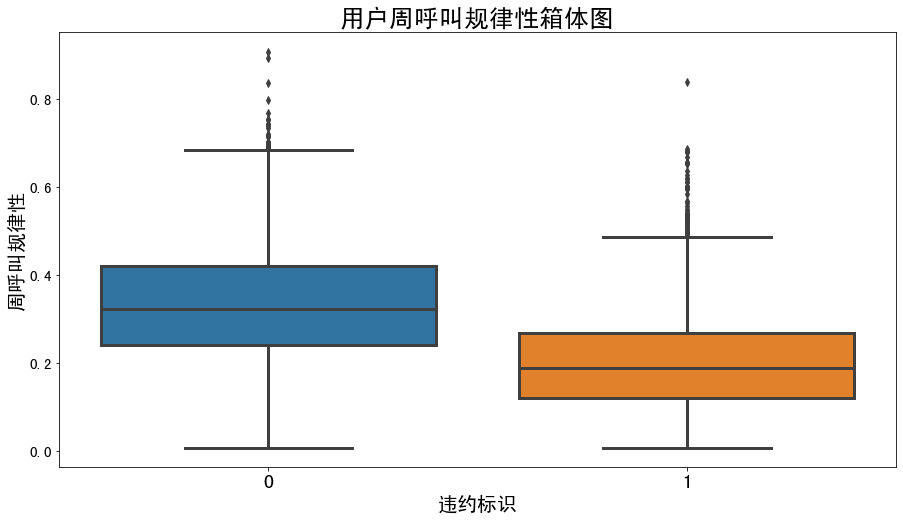

In [97]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x=user_features['RISK_Flag'], y=user_features["weekly_opp"], linewidth=3)
plt.title('用户周呼叫规律性箱体图', fontsize=25)
ax.set_xlabel('违约标识', fontsize=20)
ax.set_ylabel('周呼叫规律性', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

In [98]:
weekly_opp_0 = user_features[user_features['RISK_Flag']==0]['weekly_opp']
weekly_opp_1 = user_features[user_features['RISK_Flag']==1]['weekly_opp']

# 守信用户与违约用户在该特征上的中位数与标准差
print("守信用户周呼叫规律性中位数:", np.median(weekly_opp_0))
print("违约用户周呼叫规律性中位数:", np.median(weekly_opp_1))
print("守信用户周呼叫规律性标准差:", np.std(weekly_opp_0))
print("违约用户周呼叫规律性标准差:", np.std(weekly_opp_1))

# 特征显著性分析 - levene检验与t检验
print("levene检验结果:", stats.levene(weekly_opp_0, weekly_opp_1))
print("t检验结果:", stats.ttest_ind(weekly_opp_0, weekly_opp_1))

守信用户周呼叫规律性中位数: 0.32321428571428573
违约用户周呼叫规律性中位数: 0.18750000000000003
守信用户周呼叫规律性标准差: 0.13184779976572153
违约用户周呼叫规律性标准差: 0.11363442595958913
levene检验结果: LeveneResult(statistic=80.63125179114499, pvalue=3.461087506825021e-19)
t检验结果: Ttest_indResult(statistic=45.18517419101, pvalue=0.0)


### 特征相关性分析

In [99]:
from scipy.stats import pearsonr, spearmanr

In [100]:
act_feats = ['missing_days', 'call_avg', 'callout_avg', 'callin_avg', 'opp_nums', 'opp_nums_in', 'opp_nums_out', 'Roam_type0', 'Roam_type1',
             'Roam_type4', 'Roam_type5', 'Roam_type6', 'Roam_type8', 'Toll_type0', 'Toll_type1', 'Toll_type2', 'Toll_type3', 'Toll_type4',
             'Toll_type5', 'Toll_type10', 'Duration1', 'Duration2', 'Duration3', 'Duration4', 'Duration5']
div_feats = ['opp_entropy', 'opp_entropy_day', 'duration_entropy']
reg_feats = ['callnum_diff', 'oppnum_diff', 'opp_variance_all', 'opp_variance_week', 'concen_all', 'weekly_opp']
all_feats = act_feats + div_feats + reg_feats

In [101]:
user_features = user_features[['uid']+all_feats+['RISK_Flag']]

In [102]:
user_features.head()

,uid,missing_days,call_avg,callout_avg,callin_avg,opp_nums,opp_nums_in,opp_nums_out,Roam_type0,Roam_type1,...,opp_entropy,opp_entropy_day,duration_entropy,callnum_diff,oppnum_diff,opp_variance_all,opp_variance_week,concen_all,weekly_opp,RISK_Flag
0,60015357,4,4.03125,1.71875,2.31250,63,48.0,30.0,113.0,15.0,...,3.843333,0.836872,1.353048,71,40,4.859375,4.130714,0.334600,0.175000,0
1,60015359,29,0.15625,0.00000,0.15625,3,3.0,0.0,5.0,0.0,...,0.950271,0.021661,0.000000,5,3,0.171875,0.114286,0.028571,0.021429,1
2,60015362,27,0.18750,0.03125,0.15625,6,5.0,1.0,6.0,0.0,...,1.791759,0.021661,0.693147,6,6,0.214844,0.163929,0.033929,0.037500,1
3,60015365,11,1.25000,0.18750,1.06250,28,26.0,5.0,40.0,0.0,...,3.164433,0.235623,0.439320,28,21,1.058594,0.968929,0.206696,0.117857,0
4,10032318,29,0.09375,0.00000,0.09375,3,3.0,0.0,3.0,0.0,...,1.098612,0.000000,0.000000,3,3,0.084961,0.072500,0.023214,0.023214,1


#### 特征显著性检验

In [103]:
for col in all_feats:
    df_0 = list(user_features[user_features['RISK_Flag']==0][col])
    df_1 = list(user_features[user_features['RISK_Flag']==1][col])
    if stats.levene(df_0, df_1)[1] < 0.01:
        p_val = stats.ttest_ind(df_0,df_1,equal_var=False)[1]
    else:
        p_val = stats.ttest_ind(df_0,df_1,equal_var=True)[1]
    if p_val < 0.01:
        print('col name: {}, p_value: {}'.format(col, p_val))
    else:
        print('col name: {}, p_value: {}, p value小于0.01认为不显著'.format(col, p_val))

col name: missing_days, p_value: 0.0
col name: call_avg, p_value: 0.0
col name: callout_avg, p_value: 4.4657837899681274e-265
col name: callin_avg, p_value: 0.0
col name: opp_nums, p_value: 0.0
col name: opp_nums_in, p_value: 0.0
col name: opp_nums_out, p_value: 3.6920760197000265e-291
col name: Roam_type0, p_value: 4.631716440177792e-299
col name: Roam_type1, p_value: 2.663063516205995e-19
col name: Roam_type4, p_value: 9.923935087328029e-15
col name: Roam_type5, p_value: 0.0032418283300641665
col name: Roam_type6, p_value: 5.113693707557935e-06
col name: Roam_type8, p_value: 0.08081925430672986, p value小于0.01认为不显著
col name: Toll_type0, p_value: 0.0
col name: Toll_type1, p_value: 9.017357575107869e-54
col name: Toll_type2, p_value: 0.059146997321056625, p value小于0.01认为不显著
col name: Toll_type3, p_value: 0.002658274914816827
col name: Toll_type4, p_value: 0.013887752364099922, p value小于0.01认为不显著
col name: Toll_type5, p_value: 0.6584189978307191, p value小于0.01认为不显著
col name: Toll_type10,

#### 单变量相关性分析

In [104]:
for col in all_feats:
    pearson_corr = pearsonr(list(user_features[col]), list(user_features['RISK_Flag']))[0]
    # spearman_corr = spearmanr(list(user_features[col]), list(user_features['RISK_Flag']))[0]
    if abs(pearson_corr) > 0.1:
        print("{},\t pearson:{:.4}\t".format(col, pearson_corr))
    else:
        print("{},\t pearson:{:.4}\t, 相关性低于0.1认为相关性较低".format(col, pearson_corr))

missing_days,	 pearson:0.4666	
call_avg,	 pearson:-0.4416	
callout_avg,	 pearson:-0.4064	
callin_avg,	 pearson:-0.4416	
opp_nums,	 pearson:-0.465	
opp_nums_in,	 pearson:-0.4587	
opp_nums_out,	 pearson:-0.4254	
Roam_type0,	 pearson:-0.4296	
Roam_type1,	 pearson:-0.107	
Roam_type4,	 pearson:-0.0921	, 相关性低于0.1认为相关性较低
Roam_type5,	 pearson:-0.03514	, 相关性低于0.1认为相关性较低
Roam_type6,	 pearson:-0.05438	, 相关性低于0.1认为相关性较低
Roam_type8,	 pearson:-0.02108	, 相关性低于0.1认为相关性较低
Toll_type0,	 pearson:-0.4429	
Toll_type1,	 pearson:-0.1835	
Toll_type2,	 pearson:-0.02278	, 相关性低于0.1认为相关性较低
Toll_type3,	 pearson:-0.03574	, 相关性低于0.1认为相关性较低
Toll_type4,	 pearson:-0.0297	, 相关性低于0.1认为相关性较低
Toll_type5,	 pearson:-0.005337	, 相关性低于0.1认为相关性较低
Toll_type10,	 pearson:-0.1666	
Duration1,	 pearson:-0.4292	
Duration2,	 pearson:-0.4169	
Duration3,	 pearson:-0.3943	
Duration4,	 pearson:-0.3721	
Duration5,	 pearson:-0.3219	
opp_entropy,	 pearson:-0.466	
opp_entropy_day,	 pearson:-0.564	
duration_entropy,	 pearson:-0.2093	
callnum_diff

#### 特征之间的相关性

In [105]:
corr = user_features[all_feats].corr()

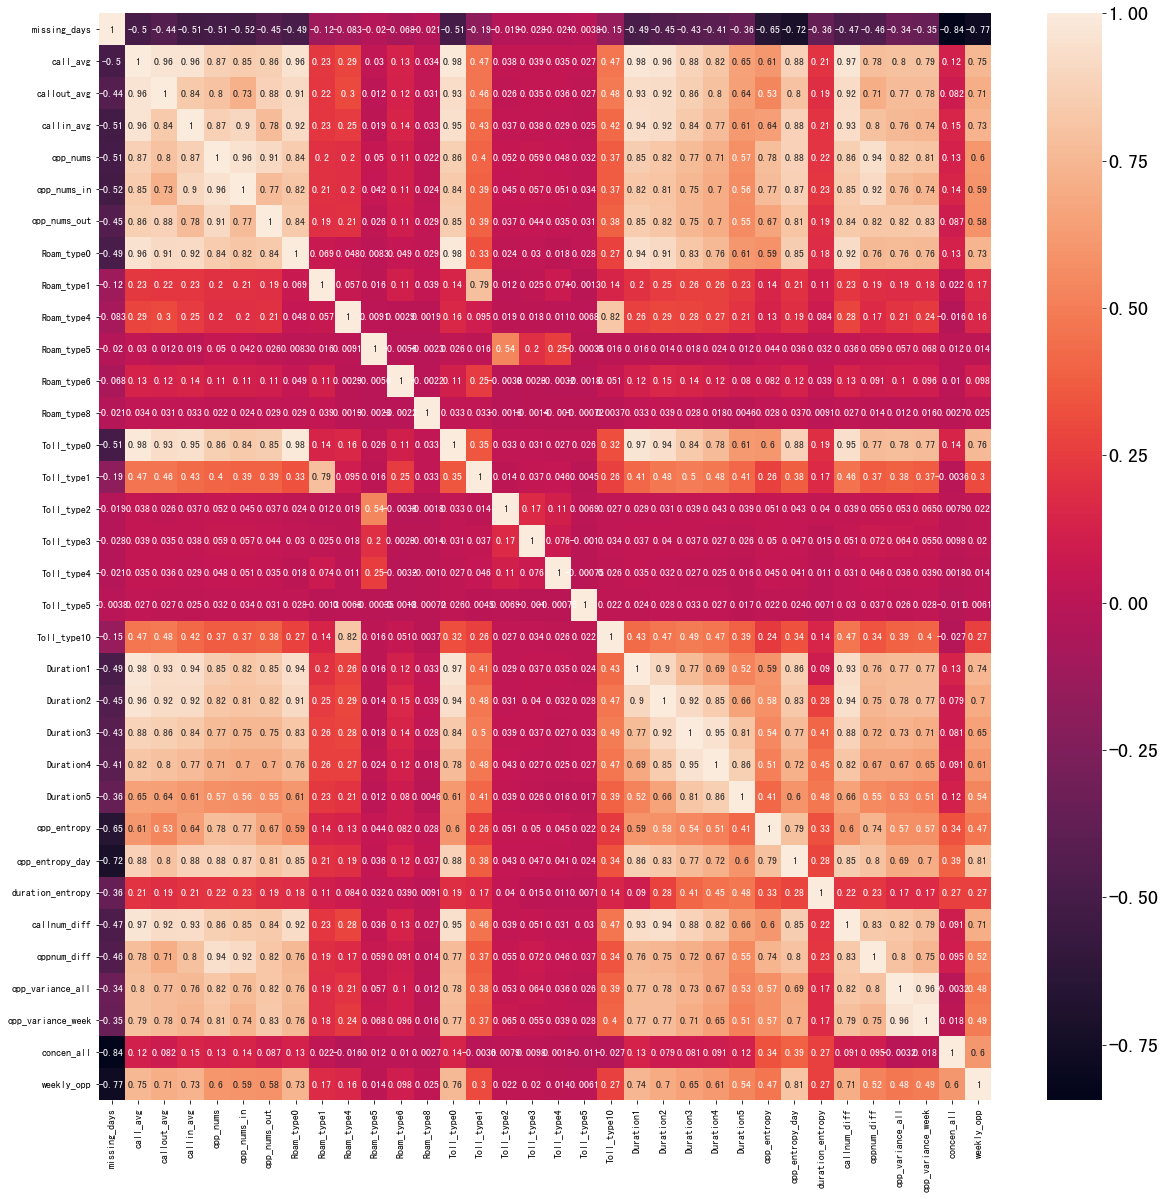

In [106]:
plt.figure(figsize=(20, 20))
g = sns.heatmap(corr, annot=True, annot_kws={"fontsize":10})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize=10)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize=10)
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
# plt.savefig('corr_heatmap.png')

In [107]:
# 从特征中剔除掉显著性与单变量相关性低的特征

user_features = user_features.drop(['Roam_type4', 'Roam_type5', 'Roam_type6', 
                                    'Roam_type8', 'Toll_type2', 'Toll_type3', 'Toll_type4', 'Toll_type5'], axis=1)

## 建立用户信用预测模型

In [108]:
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score

from xgboost import XGBClassifier
import lightgbm as lgb

### 对特征进行标准化处理

In [109]:
X = user_features.values[:, 1:-1]
y = user_features.values[:, -1]

In [110]:
def feats_normalize(X):
    X = normalize(X, norm='l2', axis=0)
    return X

In [111]:
X = feats_normalize(X)

### 设定模型，网格搜索进行模型参数调优

In [112]:
model_list = ['lr', 'rf', 'svm', 'xgb', 'lgb', 'dt', 'dnn']

In [113]:
# model_params = {
#     'lr': {"penalty": ["l2"], "C": [0.01, 0.1, 1, 10, 100]},
#     'svm': [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
#             {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
#     'rf': {'n_estimators': [10, 50, 100, 200, 300],
#             'max_features': ['auto', 'sqrt', 'log2'],
#             'max_depth': [5, 10, 20],
#             'criterion': ['gini', 'entropy']},
#     'xgb': {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
#             'n_estimators': [50, 100, 200, 500, 700],
#             'max_depth': [1, 5, 10, 20],
#             'min_child_weight': [1, 3, 5, 7],
#             'gamma': [0.1, 0.3, 0.5, 0.7]},
#     'lgb': {'n_estimators': [50, 100, 200, 500],
#             'max_depth': [4,6,8],
#             'num_leaves': [20,30,40],
#             'min_child_samples': [10, 20, 30],
#             'min_child_weight': [0.01, 0.1, 1],
#            },
#     'dt': {'criterion':['gini'], 
#            'max_depth':[5, 10, 30, 50], 
#            'min_samples_leaf':[2, 3, 5, 10], 
#            'min_impurity_decrease':[0.1, 0.2, 0.5]}
# }

In [114]:
# for model_name in model_list:
#     if model_name == 'lr':
#         model = LogisticRegression()
#     elif model_name == 'rf':
#         model = RandomForestClassifier()
#     elif model_name == 'svm':
#         model = SVC()
#     elif model_name == 'xgb':
#         model = XGBClassifier()
#     elif model_name == 'lgb':
#         model = lgb.LGBMClassifier(boosting_type='gbdt')
#     elif model_name == 'dt':
#         model = DecisionTreeClassifier()
    
#     gr_search = GridSearchCV(model, model_params[model_name], scoring='roc_auc', cv=3)
#     gr_search.fit(X_train, y_train)
#     print("Best parameters set:")
#     print()
#     print("Model {} params: ".format(model_name), gr_search.best_params_)
#     print()
#     y_pred = gr_search.predict(X_test)
#     print(classification_report(y_test, y_pred))
##     y_pred = model.predict(X_test)
##     acc = accuracy_score(y_test, y_pred)
##     f1_val = f1_score(y_test, y_pred)
##     precision = precision_score(y_test, y_pred)
##     recall = recall_score(y_test, y_pred)
##     print('model: {}, acc: {:.4f}, f1: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(model_name, acc, f1_val, precision, recall))

### 模型训练与评估

In [115]:
from sklearn.model_selection import KFold

acc_results = {'lr': [],'rf': [],'svm': [],'xgb': [],'lgb': [],'dt': [],'dnn': []}
f1_results = {'lr': [],'rf': [],'svm': [],'xgb': [],'lgb': [],'dt': [],'dnn': []}
recall_results = {'lr': [],'rf': [],'svm': [],'xgb': [],'lgb': [],'dt': [],'dnn': []}
precision_results = {'lr': [],'rf': [],'svm': [],'xgb': [],'lgb': [],'dt': [],'dnn': []}
auc_results = {'lr': [],'rf': [],'svm': [],'xgb': [],'lgb': [],'dt': [],'dnn': []}

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    for model_name in model_list:
        if model_name == 'lr':
            model = LogisticRegression(C=100, penalty='l2')
        elif model_name == 'rf':
            model = RandomForestClassifier(max_depth=5, max_features='auto', n_estimators=50)
        elif model_name == 'svm':
            model = SVC(C=100, kernel='linear')
        elif model_name == 'xgb':
            model = XGBClassifier(gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200)
        elif model_name == 'lgb':
            model = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=4, min_child_samples=20, min_child_weight=1, n_estimators=50, num_leaves=20)
        elif model_name == 'dt':
            model = DecisionTreeClassifier(criterion='gini', max_depth=5, min_impurity_decrease=0.1, min_samples_leaf=2)
        elif model_name == 'dnn':
            model = MLPClassifier(hidden_layer_sizes=(100,100))

        model.fit(X[train_index], y[train_index])
        y_test = y[test_index]
        y_pred = model.predict(X[test_index])
        acc = accuracy_score(y_test, y_pred)
        f1_val = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        
        acc_results[model_name].append(acc)
        f1_results[model_name].append(f1_val)
        recall_results[model_name].append(recall)
        precision_results[model_name].append(precision)
        auc_results[model_name].append(auc)

In [116]:
print("各模型的预测准确率：")
for model_name in model_list:
    print("{} acc: {}".format(model_name, np.mean(acc_results[model_name])))
print()
    
print("各模型预测的f1值：")
for model_name in model_list:
    print("{} f1: {}".format(model_name, np.mean(f1_results[model_name])))
print()
    
print("各模型的预测召回率：")
for model_name in model_list:
    print("{} recall: {}".format(model_name, np.mean(recall_results[model_name])))
print()
    
print("各模型的预测精确率：")
for model_name in model_list:
    print("{} precision: {}".format(model_name, np.mean(precision_results[model_name])))
print()
    
print("各模型预测的AUC值：")
for model_name in model_list:
    print("{} auc: {}".format(model_name, np.mean(auc_results[model_name])))

各模型的预测准确率：
lr acc: 0.7588561363573627
rf acc: 0.7639555229021169
svm acc: 0.7578365775610004
xgb acc: 0.7624966290751032
lgb acc: 0.7646830056546601
dt acc: 0.74850967959757
dnn acc: 0.7575436521502785

各模型预测的f1值：
lr f1: 0.761488881275137
rf f1: 0.7676112432269502
svm f1: 0.7703878434175904
xgb f1: 0.7673032170031145
lgb f1: 0.7683011283698693
dt f1: 0.7662966120514709
dnn f1: 0.760042752611412

各模型的预测召回率：
lr recall: 0.7864354480181339
rf recall: 0.7966735077338082
svm recall: 0.8306581197038732
xgb recall: 0.8010335445420758
lgb recall: 0.7981529738752
dt recall: 0.8436938996963084
dnn recall: 0.784235117439613

各模型的预测精确率：
lr precision: 0.7389719785727353
rf precision: 0.741563844330474
svm precision: 0.7197180728064408
xgb precision: 0.7370113069463201
lgb precision: 0.7413718582593364
dt precision: 0.7023263702176307
dnn precision: 0.739689455982137

各模型预测的AUC值：
lr auc: 0.7587922044845337
rf auc: 0.7637081400846714
svm auc: 0.7593283229672105
xgb auc: 0.76239728074065
lgb auc: 0.764

### 特征重要性

In [117]:
model = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=4, min_child_samples=20, min_child_weight=1, n_estimators=50, num_leaves=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
model.feature_importances_

array([18, 12, 31, 23, 64, 22, 54, 25, 11,  8, 22, 22,  9, 21, 40, 14, 16,
       18, 37, 17, 18, 35, 10, 18, 34, 36], dtype=int32)

In [118]:
feat_imp_df = pd.DataFrame({
    'Features': user_features.columns[1:-1],
    'Feature importances': model.feature_importances_
}).sort_values('Feature importances', ascending=False)

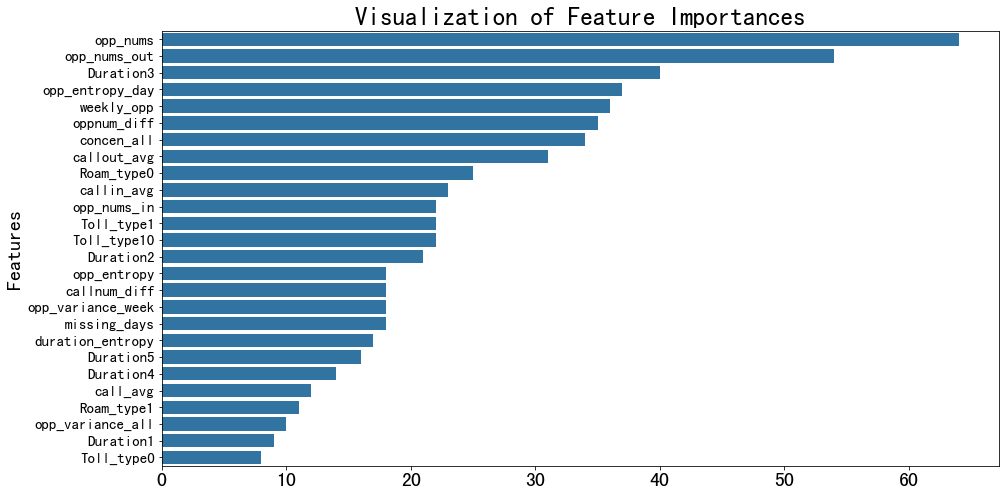

In [119]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=feat_imp_df, y='Features', x='Feature importances', orient='h', color='tab:blue')
plt.title('Visualization of Feature Importances', fontsize=25)
ax.set_xlabel('')
ax.set_ylabel('Features', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()